# Import

In [1]:
## Imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dexplot as dxp

from scipy.stats import chi2_contingency
from os.path import exists
from importlib import reload

import model
import wrangle
import warnings
warnings.filterwarnings("ignore")

# %matplotlib notebook


In [2]:
reload(wrangle)

<module 'wrangle' from '/Users/sinao/coding_projects/oct_2022_unemployment_project/wrangle.py'>

In [3]:
train = wrangle.wrangle_oct(explore=True)

# Explore 

## Univariate

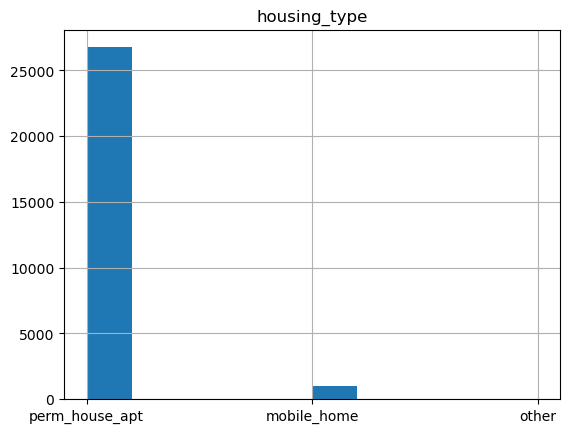

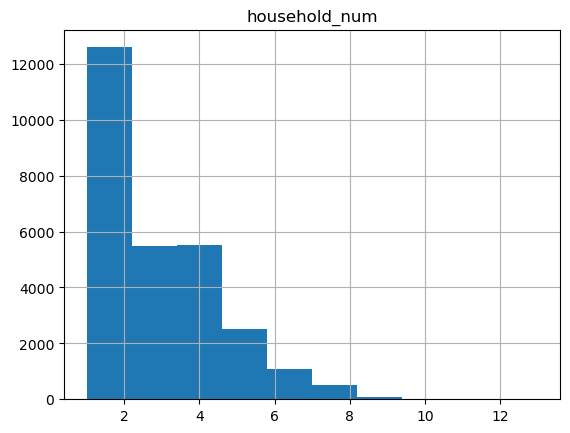

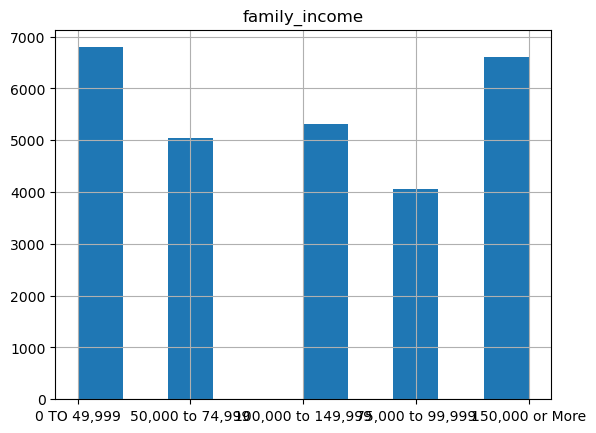

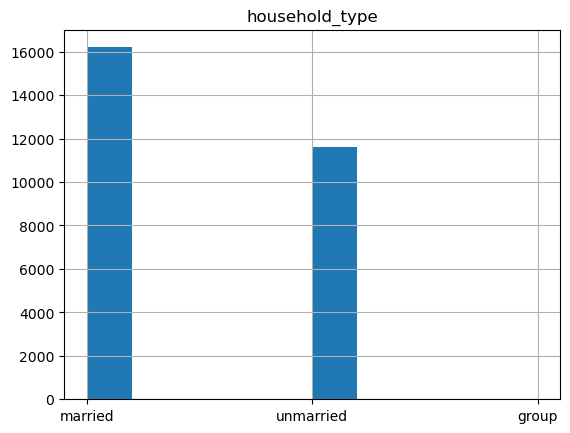

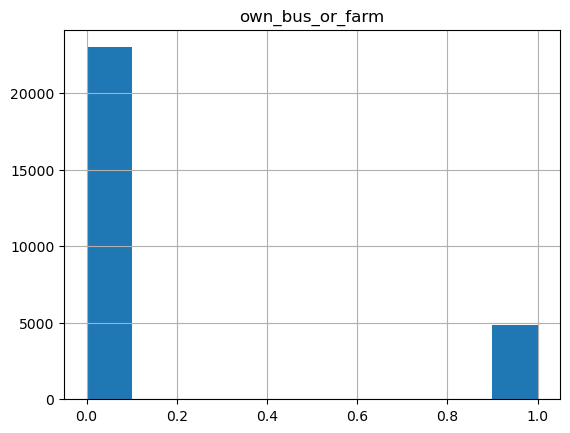

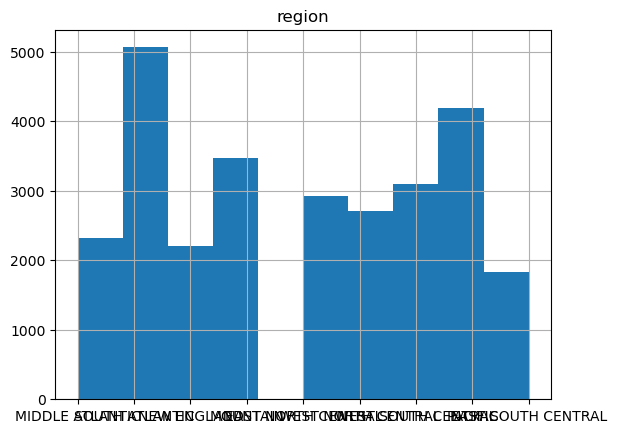

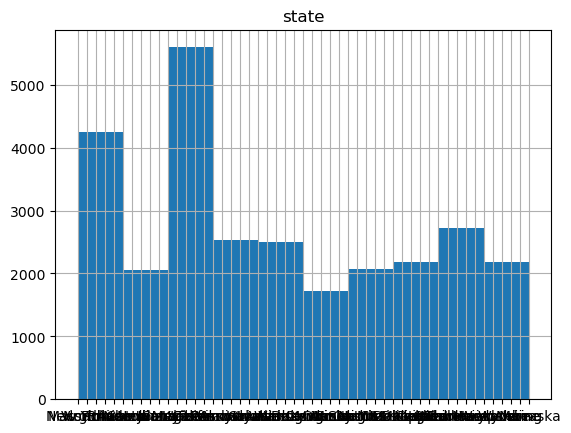

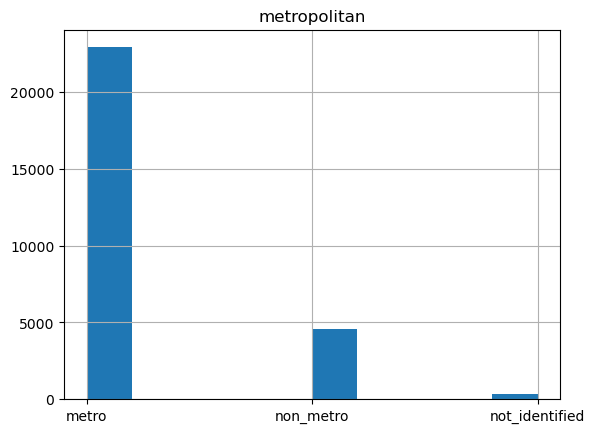

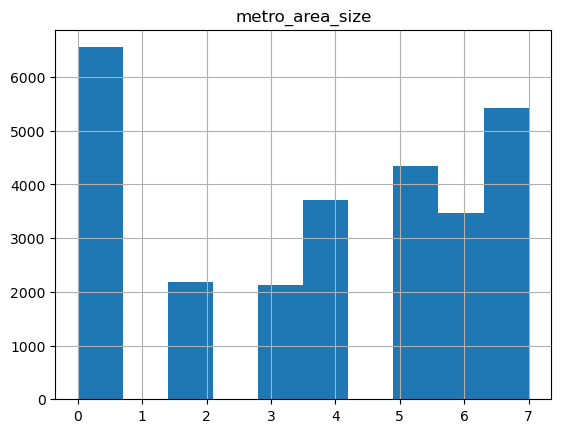

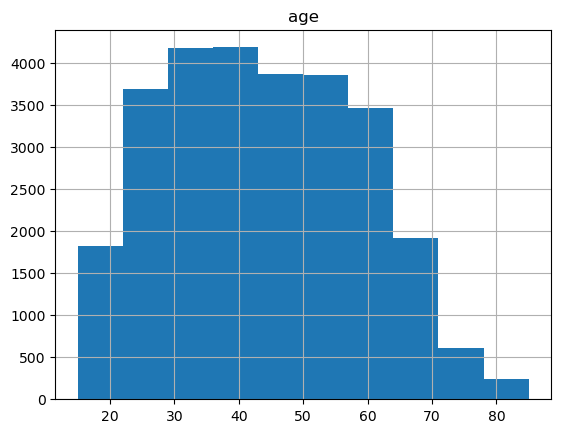

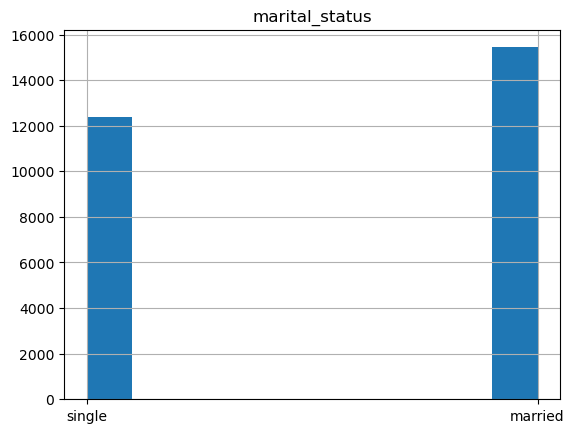

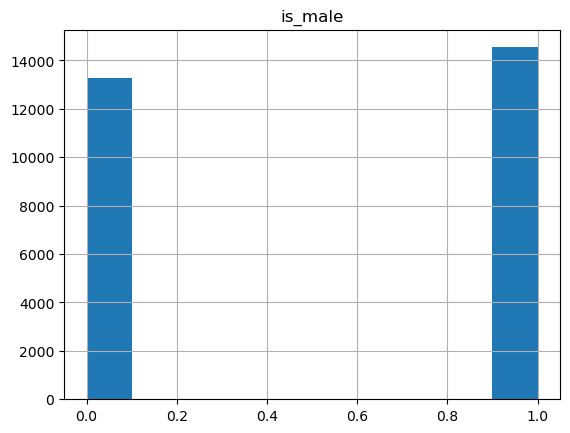

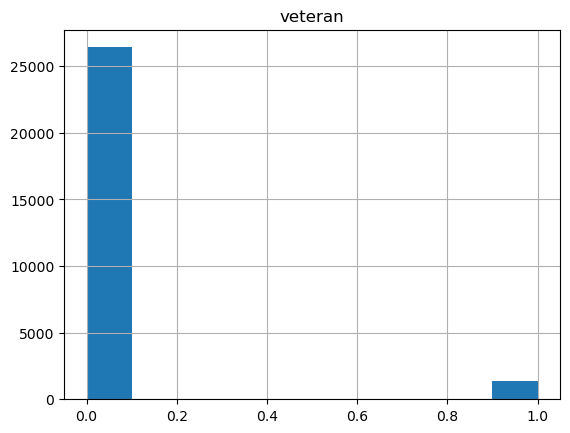

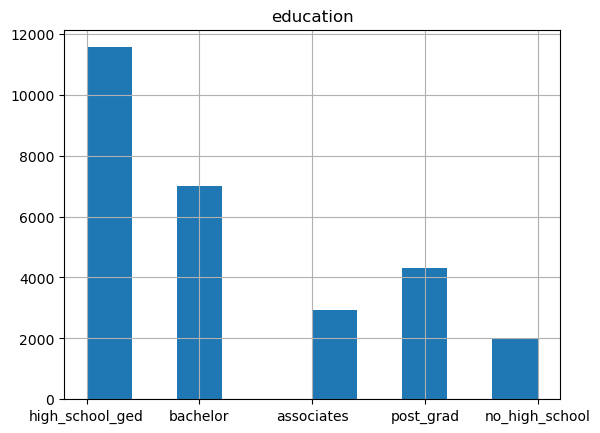

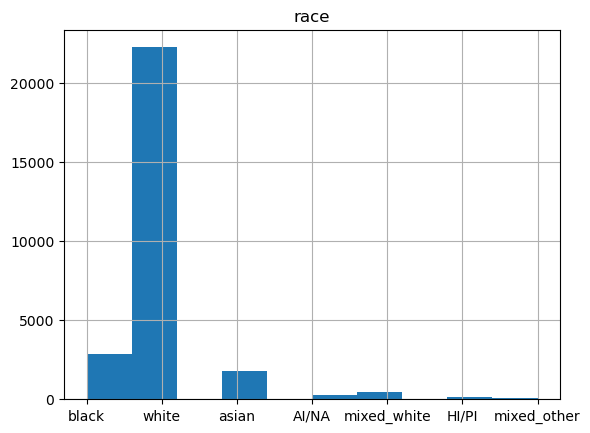

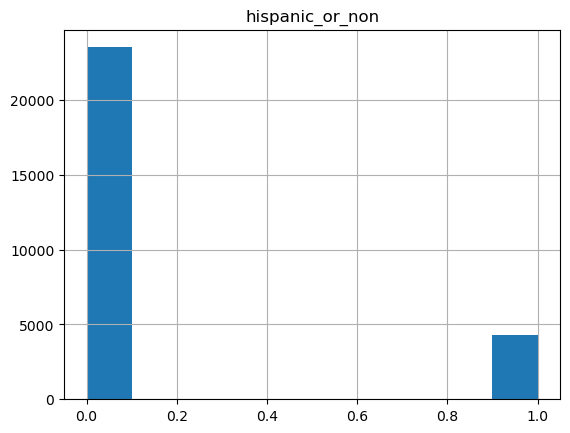

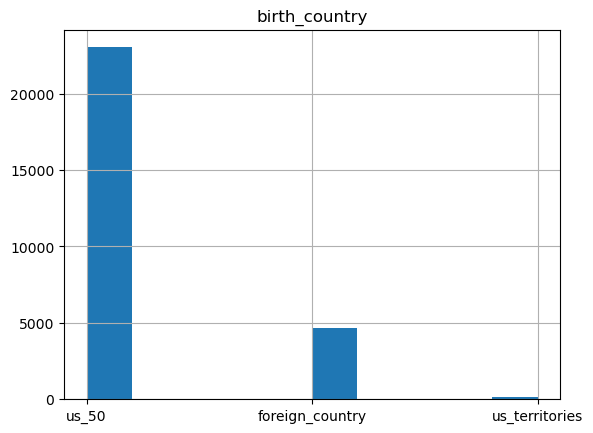

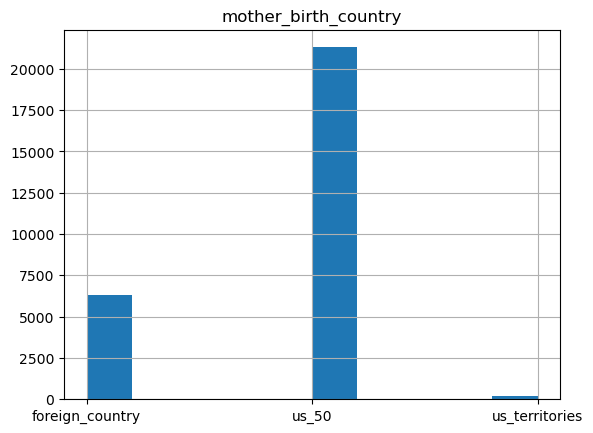

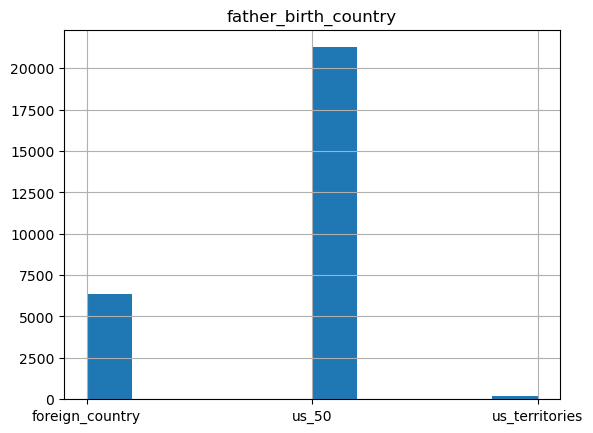

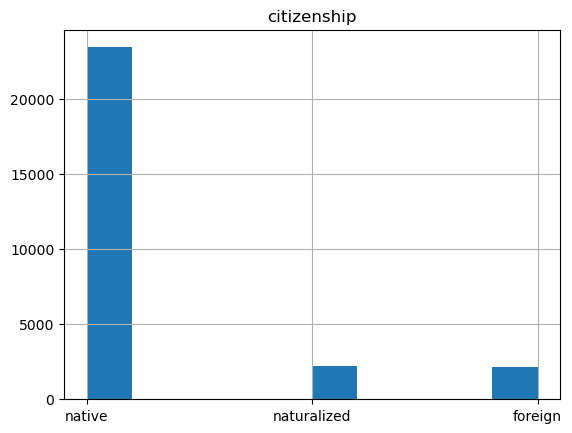

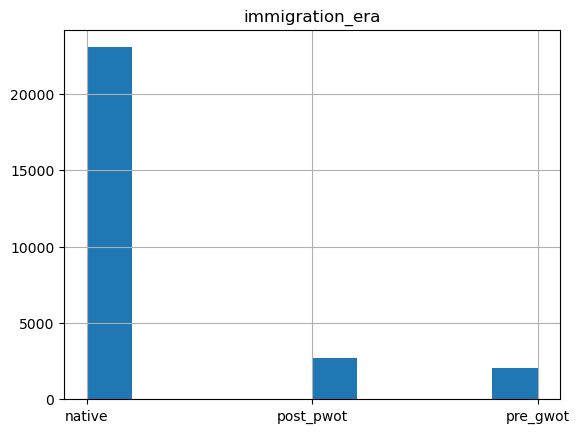

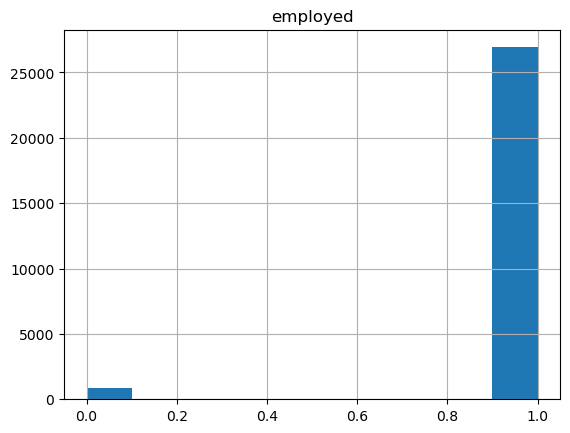

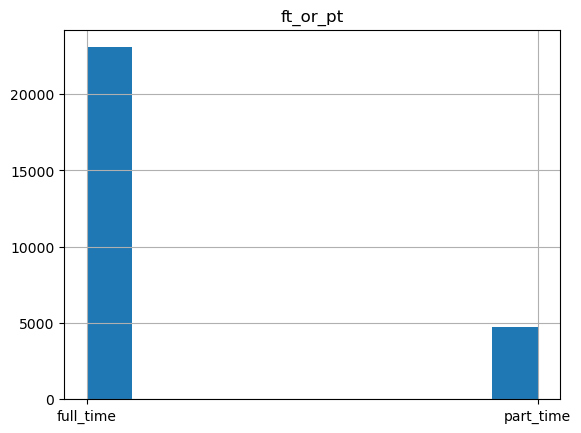

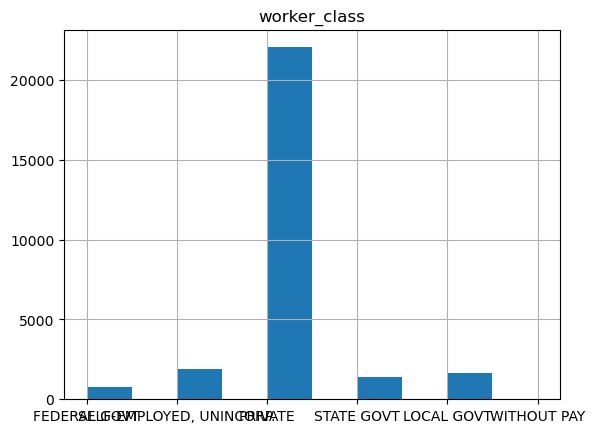

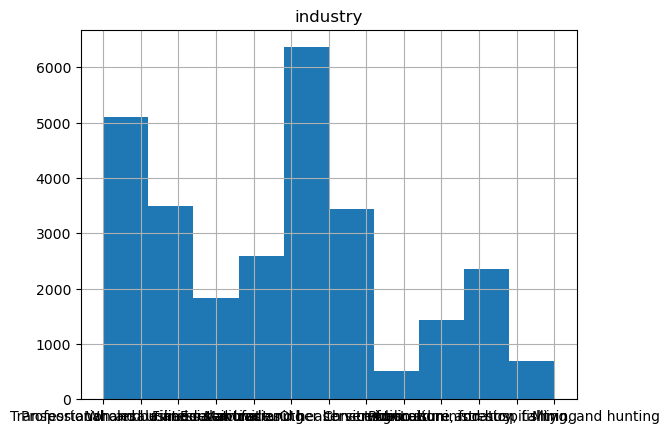

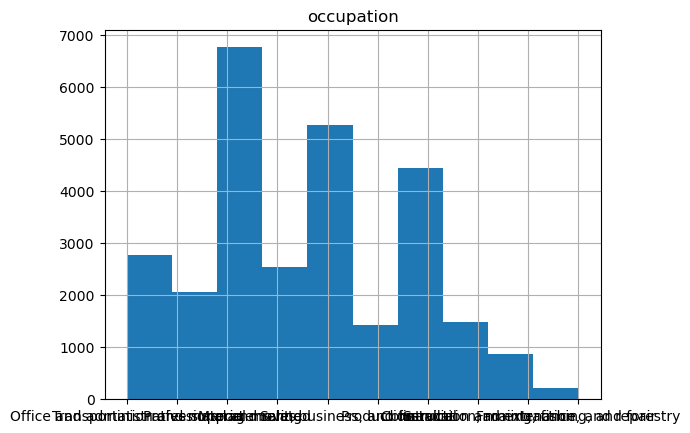

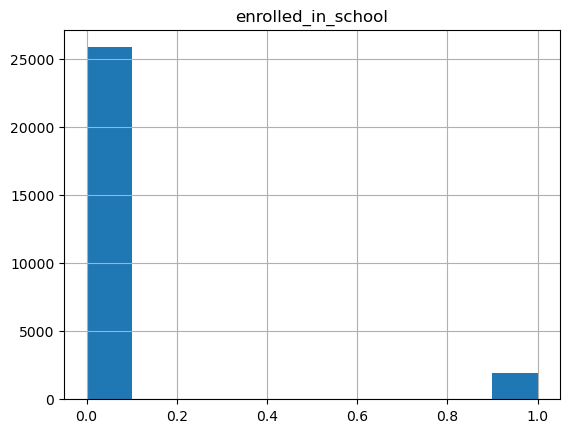

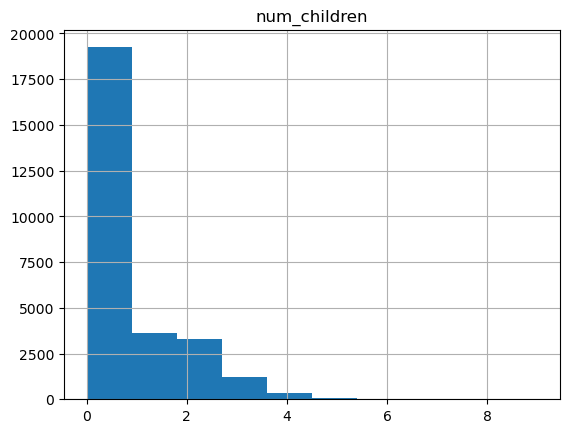

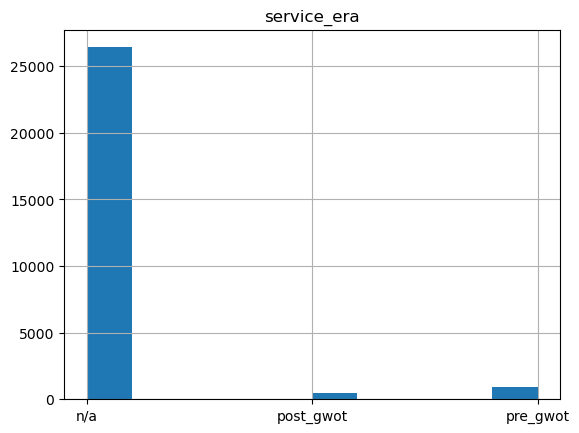

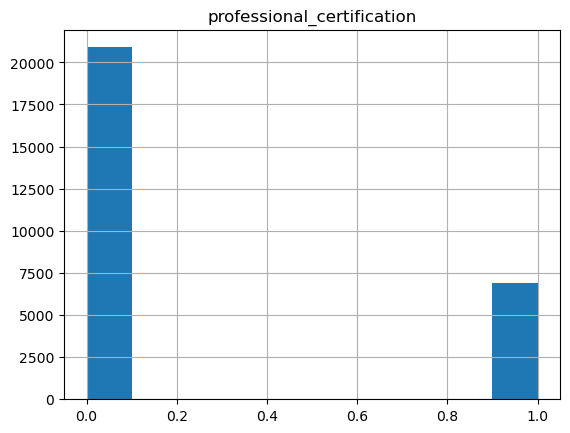

In [4]:
for col in train.columns:
    train[col].hist()
    plt.title(col)
    plt.show()

### Takeaways
* Skewed:
    - `family_income`, `household_num`, 'household_type`
* many responses from region 5 (south_atlantic)
* almost all respondents worked in last 12 months (train split)
* eliminate - `could_have_started_job`

## Bivariate - Pairplots 
* Examine variables in relationship to each other

In [5]:
# create column filter lists for plotting use

#fixing types on categorical columns
categorical_cols = ['housing_type','family_income','household_type',
                'region','state','metropolitan','metro_area_size',
                'marital_status','education','race','birth_country',
                'mother_birth_country','father_birth_country','citizenship',
                'industry','occupation']

binary_cols = ['own_bus_or_farm', 'is_male', 'veteran','hispanic_or_non', 
                'employed', 'enrolled_in_school','professional_certification']  

continuous_cols = ['age', 'household_num','num_children'] 

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27815 entries, 2853 to 29968
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   housing_type                27815 non-null  object  
 1   household_num               27815 non-null  float64 
 2   family_income               27815 non-null  category
 3   household_type              27815 non-null  object  
 4   own_bus_or_farm             27815 non-null  int64   
 5   region                      27815 non-null  object  
 6   state                       27815 non-null  object  
 7   metropolitan                27815 non-null  object  
 8   metro_area_size             27815 non-null  float64 
 9   age                         27815 non-null  float64 
 10  marital_status              27815 non-null  object  
 11  is_male                     27815 non-null  int64   
 12  veteran                     27815 non-null  int64   
 13  education    

In [7]:
def plot_continuous_pairs (df, col_list):
    """ 
    Purpose
        Plot pairwise relationships of zillow dataframe
        Ignores Categorical columns
    
    Parameters
        df: a dataframe containing zillow real estate data

    Returns
        None
    """

    #initialize a seaborn pairgrid
    g = sns.PairGrid(df[col_list])
    
    #fills out the pairgrid with a regplot
    g.map(sns.regplot, line_kws={'color':'r'})
    return 

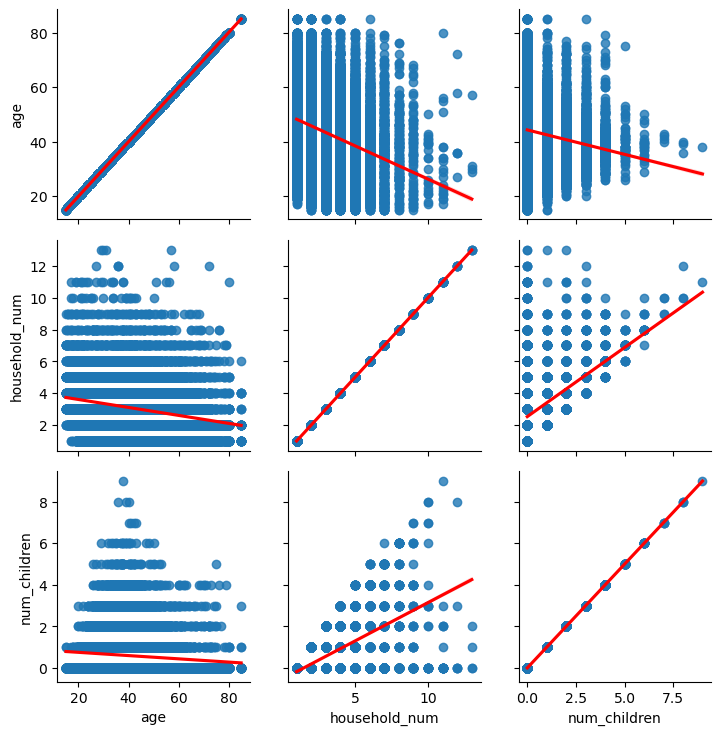

In [8]:
plot_continuous_pairs(train, continuous_cols)

### Takeaways
- Increases in age track with decreases in home size

## Bivariate - Categorical Plotting

In [9]:
unemployed = train[train.employed == 0]
employed = train[train.employed == 1]

In [10]:
unemployed.groupby('industry').size()

industry
Agriculture, forestry, fishing, and hunting     12
Construction                                    81
Educational and health services                144
Financial activities                            29
Information                                     17
Leisure and hospitality                        134
Manufacturing                                   83
Mining                                           4
Other services                                  35
Professional and business services             115
Public administration                           18
Transportation and utilities                    67
Wholesale and retail trade                     148
dtype: int64

In [11]:
employed.groupby('industry').size()

industry
Agriculture, forestry, fishing, and hunting     544
Construction                                   1966
Educational and health services                6217
Financial activities                           1803
Information                                     492
Leisure and hospitality                        2228
Manufacturing                                  2514
Mining                                          133
Other services                                 1351
Professional and business services             3318
Public administration                          1420
Transportation and utilities                   1601
Wholesale and retail trade                     3341
dtype: int64

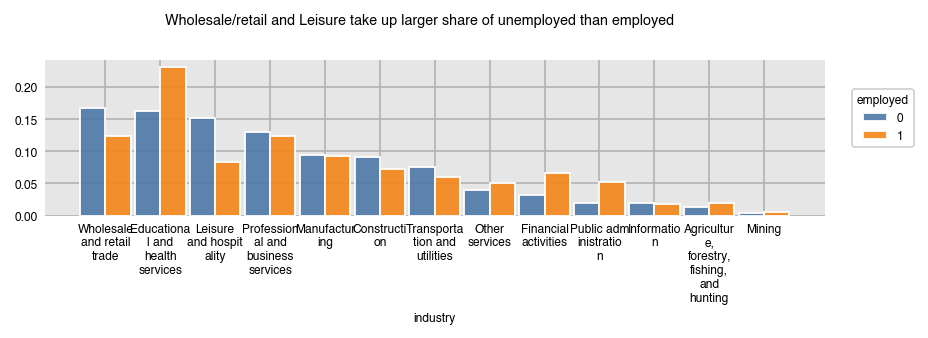

In [12]:
dxp.count('industry', data=train, split='employed', normalize='employed', title='Wholesale/retail and Leisure take up larger share of unemployed than employed')

### Takeaway
    Wholesale/retail and Leisure take up larger share of unemployed that employed

In [13]:
for col in train[categorical_cols]:
    dxp.count('industry', data=train, split='employed', normalize='employed')

### Takeaways
* Look for proportionality differences between employed vs not
* Columns for closer inspection
    - `occupation`, `industry`, `marital_status`, `race` 

### Bivariate - Binary Columns

<Figure size 2000x600 with 0 Axes>

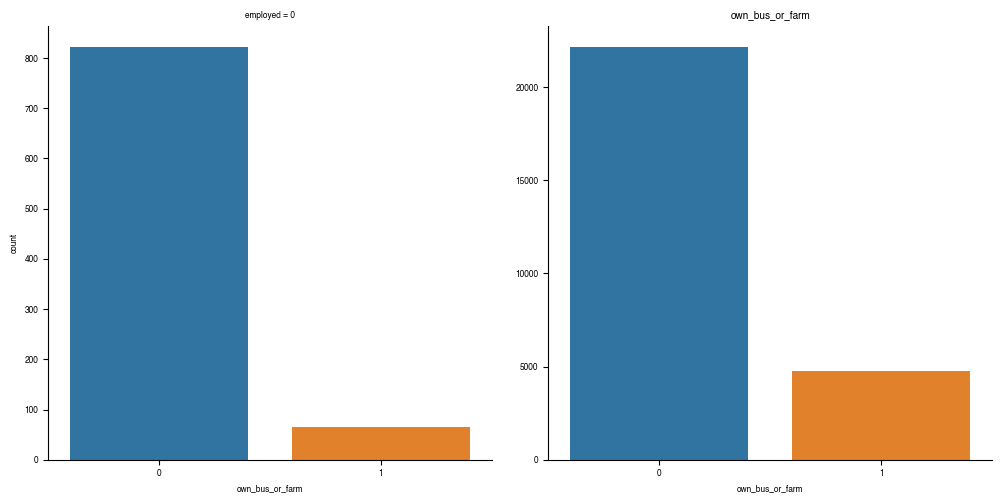

<Figure size 2000x600 with 0 Axes>

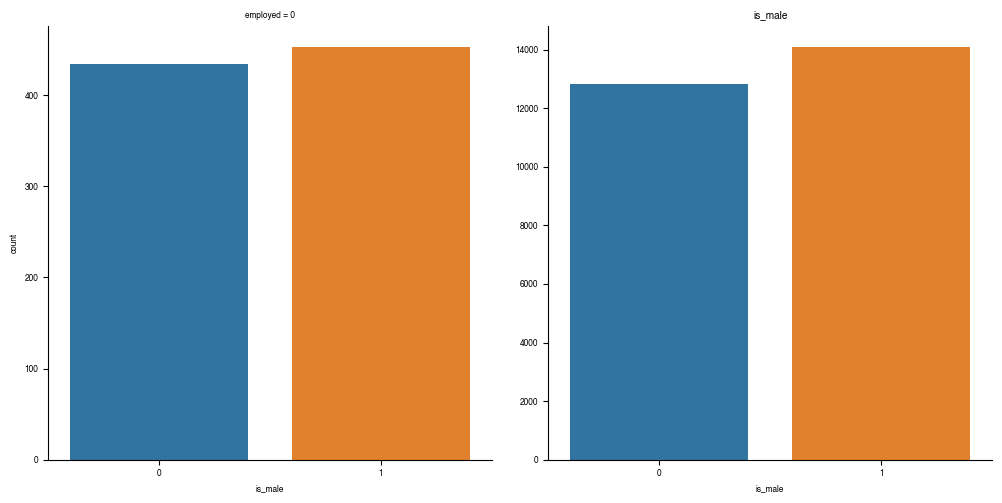

<Figure size 2000x600 with 0 Axes>

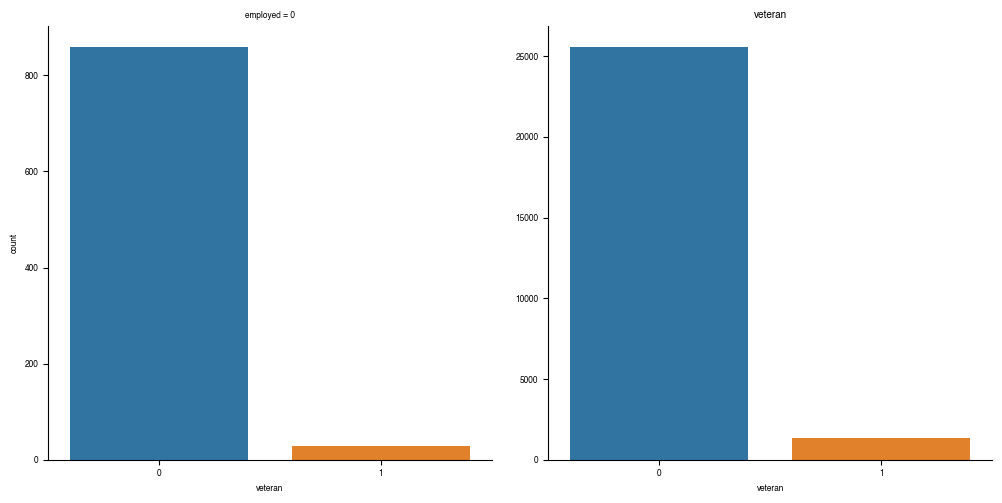

<Figure size 2000x600 with 0 Axes>

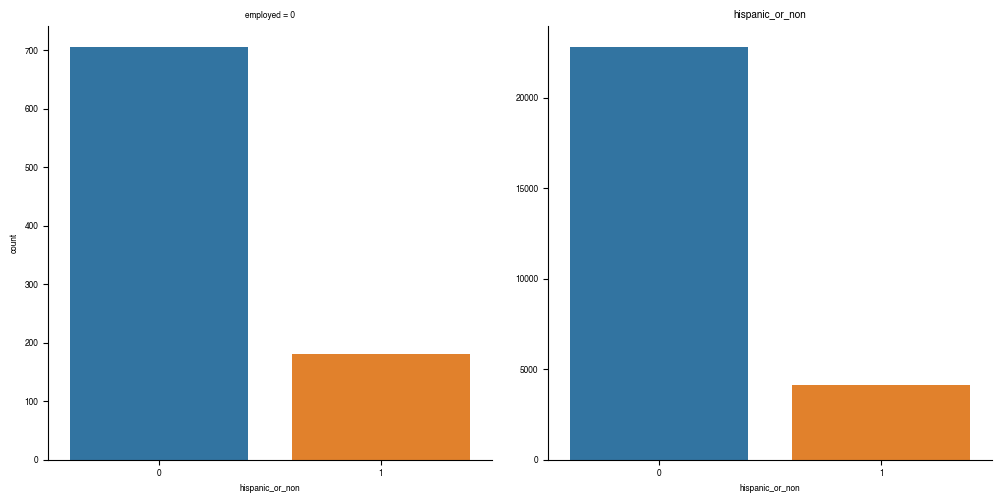

<Figure size 2000x600 with 0 Axes>

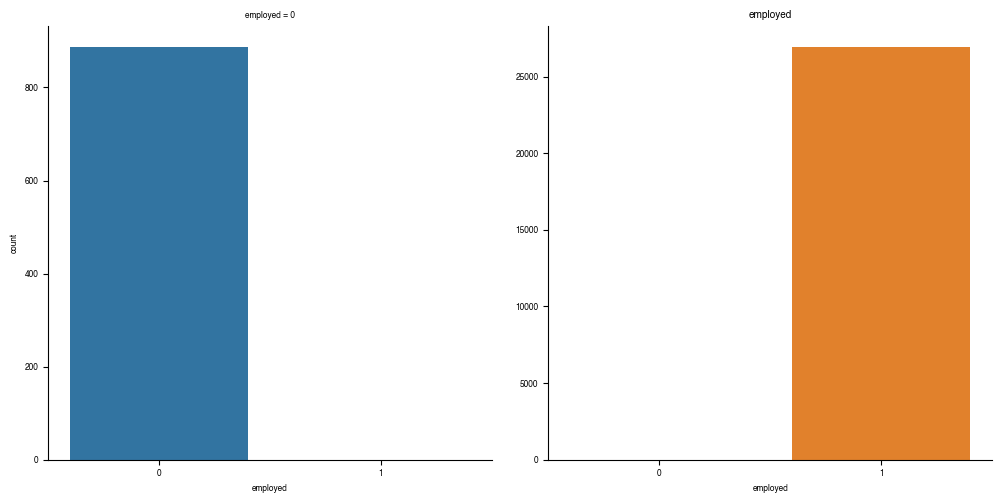

<Figure size 2000x600 with 0 Axes>

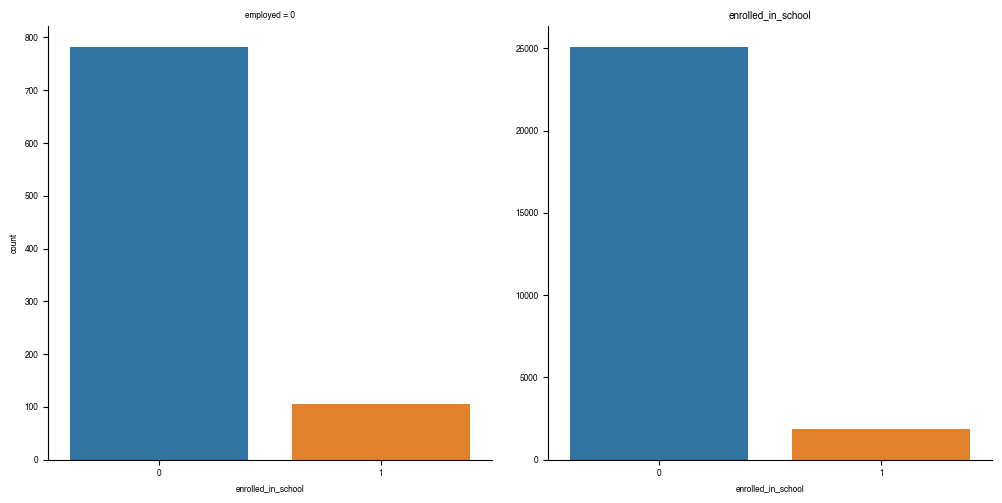

<Figure size 2000x600 with 0 Axes>

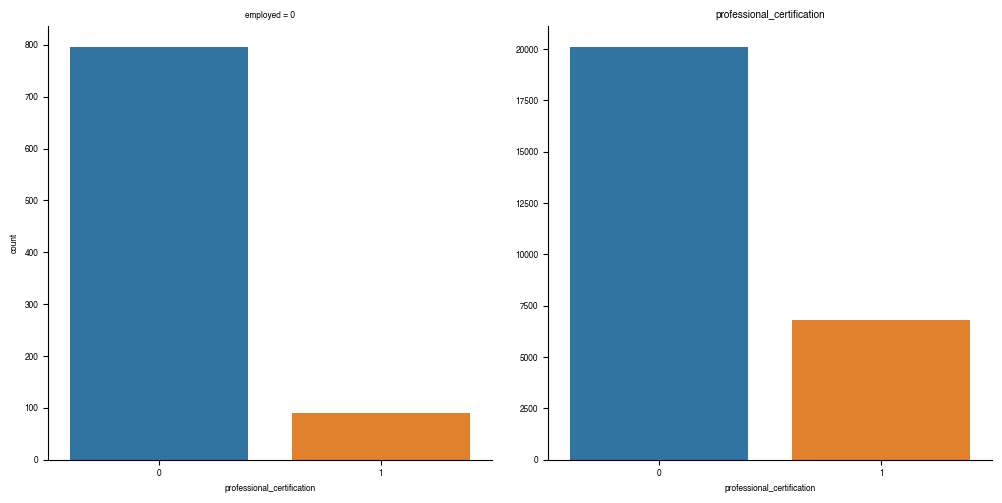

In [14]:
#loops throughs binary columns to creates a seaborn catplot for display

for col in train[binary_cols]:
    plt.figure(figsize=(20,6))
    sns.catplot(data=train, x=col, col='employed', kind='count', sharey=False, orient='y')
    #plt.axhline(y=train.employed.mean(), color='red', linestyle='dashed', label='Employement Percentage')
    plt.title(col)
    plt.show()

---
### Takeaways
* Gender reversal between employed and not,  change `is_male` --> `is_male` 
* Columns for closer inspection  
    * `professional_certification`  </b> 
---

## Specific Questions with plots and tests
* Goal:
    Create function for display of unemployment rate and population proportions of column values
* Flow:
    - Chi-2 --> t-test --> feature inclusion
* can bin interesting vs not intersting during feature selection for features the have categories that deviate 

## Spotlight Stats Function

In [15]:
# exported to model.py

def spotlight_stats(df, feature, title=None, phase=None):

    ''' 
    Purpose:
        To create visuals and print statistics for the feature of the data set
    ---
    Parameters:
        df: dataframe containing features
        feature: the feature (column) to be used for testing and visualization
        phase: the phase of the pipeline for which the output is needed
    ---
    Output:
        prop_df: dataframe that contains population proportions and unemployment rate
    ---
    '''

    multi_col = pd.MultiIndex.from_tuples([('population_proportions', 'employed'), 
                                    ('population_proportions', 'unemployed'),
                                    ('population_proportions', 'change')])
    
    # dataframe, 3 columns, 
    prop_df = pd.DataFrame(columns=multi_col)
    prop_df['unemployment_rate'] = round(1 - df.groupby(by=feature).employed.mean().sort_values(ascending=True), 4)

    # i want to show the proportion of the population that each categorical option is
    employed_pop_proportion = df[df.employed == 1][feature].value_counts(normalize=True).sort_index() 

    # i want to show the proportion of the population that each categorical option is
    unemployed_pop_proportion = df[df.employed == 0][feature].value_counts(normalize=True).sort_index()
    
    #assign proper values to dframe
    prop_df[('population_proportions', 'employed')] = employed_pop_proportion
    prop_df[('population_proportions', 'unemployed')] = unemployed_pop_proportion
    prop_df[('population_proportions', 'change')] = unemployed_pop_proportion - employed_pop_proportion

    #chi2 test
    alpha = .05
    crosstab = pd.crosstab(df[feature], df["employed"])

    chi2, p, dof, expected = chi2_contingency(crosstab)

    #prints crosstab only if phase of project is explore. during model phase just plots graph
    if phase == 'explore':
        print('Crosstab\n')
        print(crosstab.values)
        print('---\nExpected\n')
        print(f'{expected.astype(int)}')
        print('---\n')

    print(f'chi^2: {chi2:.4f}')
    print(f'p: {p:.4f}')
    print(f'degrees of freedom: {dof}')

    if p < alpha :
        print('Reject null hypothesis')
    else: 
        print('Fail to reject null hypothesis')

    prop_df['unemployment_rate'].plot(kind='barh', title='Unemployment Rate')
    #pie chart creation
    fig, axs = plt.subplots(1,2, figsize=(12,8))
    labels1 = employed_pop_proportion.index
    labels2 = unemployed_pop_proportion.index
    colors = dict(zip(labels1, plt.cm.tab20.colors[:len(labels1)]))

    axs[0].pie(employed_pop_proportion, autopct='%1.1f%%', labels=labels1, colors=[colors[key] for key in labels1])
    axs[1].pie(unemployed_pop_proportion, autopct='%1.1f%%', labels=labels2, colors=[colors[key] for key in labels1])
    plt.tight_layout()
    axs[0].set_title('Employed Proportions')
    axs[1].set_title('Unemployed Proportions')
    plt.suptitle(f'Spotlight: {title}', y=.9)
    plt.show()

    return round(prop_df, 3)

In [16]:
# creates visuals for specified dataframe which should be a subset based upon regionality

def spotlight_region_viz(df, feature, title=None, phase=None):

    ''' 
    Purpose:
        To create visuals for the feature of the data set
    ---
    Parameters:
        df: dataframe containing features
        feature: the feature (column) to be used for testing and visualization
        phase: the phase of the pipeline for which the output is needed
    ---
    Output:
        prop_df: dataframe that contains population proportions and unemployment rate
    ---
    '''

    multi_col = pd.MultiIndex.from_tuples([('population_proportions', 'employed'), 
                                    ('population_proportions', 'unemployed'),
                                    ('population_proportions', 'change')])
    
    # dataframe, 3 columns, 
    prop_df = pd.DataFrame(columns=multi_col)
    prop_df['unemployment_rate'] = round(1 - df.groupby(by=feature).employed.mean().sort_values(ascending=True), 4)

    # i want to show the proportion of the population that each categorical option is
    employed_pop_proportion = df[df.employed == 1][feature].value_counts(normalize=True).sort_index() 

    # i want to show the proportion of the population that each categorical option is
    unemployed_pop_proportion = df[df.employed == 0][feature].value_counts(normalize=True).sort_index()
    
    #assign proper values to dframe
    prop_df[('population_proportions', 'employed')] = employed_pop_proportion
    prop_df[('population_proportions', 'unemployed')] = unemployed_pop_proportion
    prop_df[('population_proportions', 'change')] = unemployed_pop_proportion - employed_pop_proportion

    prop_df['unemployment_rate'].plot(kind='barh', title=f'{title} Unemployment Rate')
    #pie chart creation
    fig, axs = plt.subplots(1,2, figsize=(12,8))
    labels1 = employed_pop_proportion.index
    labels2 = unemployed_pop_proportion.index
    colors = dict(zip(labels1, plt.cm.tab20.colors[:len(labels1)]))

    axs[0].pie(employed_pop_proportion, autopct='%1.1f%%', labels=labels1, colors=[colors[key] for key in labels1])
    axs[1].pie(unemployed_pop_proportion, autopct='%1.1f%%', labels=labels2, colors=[colors[key] for key in labels1])
    plt.tight_layout()
    axs[0].set_title('Employed Proportions')
    axs[1].set_title('Unemployed Proportions')
    plt.suptitle(f'Spotlight: {title} {feature}', y=.9)
    plt.show()

    return round(prop_df, 3)

## Spotlight - Industry 

* **Question:** Which industry shows the largest population proportion change between employed and unemployed?  
* **Answer:** Leisure and Hospitality. This industry also has the highest unemployment rate at 6%

#### Statistical Hypothesis
>* ${H_0}$: There is no relationship between industry of typical employment and employment status   
>* ${H_a}$: There is a relationship between industry of typical employment and employment status  
* ${\alpha}$: .05  
* Result: There is enough evidence to reject our null hypothesis. **Test code below**

In [17]:
spotlight_stats(train, 'industry','Educational and Health Services Largest Grouping', orientation='h')

TypeError: spotlight_stats() got an unexpected keyword argument 'orientation'

#### Statistical Testing

In [ ]:
#chi2

alpha = .05

crosstab = pd.crosstab(train['industry'], train["employed"])

chi2, p, dof, expected = chi2_contingency(crosstab)

print('Crosstab\n')
print(crosstab.values)
print('---\nExpected\n')
print(f'{expected.astype(int)}')
print('---\n')
print(f'chi^2: {chi2:.4f}')
print(f'p: {p:.4f}')
print(f'degrees of freedom: {dof}')

if p < alpha :
    print('Reject null hypothesis')
else: 
    print('Fail to reject null hypothesis')


Crosstab

[[  12  544]
 [  81 1966]
 [ 144 6217]
 [  29 1803]
 [  17  492]
 [ 134 2228]
 [  83 2514]
 [   4  133]
 [  35 1351]
 [ 115 3318]
 [  18 1420]
 [  67 1601]
 [ 148 3341]]
---
Expected

[[  17  538]
 [  65 1981]
 [ 202 6158]
 [  58 1773]
 [  16  492]
 [  75 2286]
 [  82 2514]
 [   4  132]
 [  44 1341]
 [ 109 3323]
 [  45 1392]
 [  53 1614]
 [ 111 3377]]
---

chi^2: 122.0291
p: 0.0000
degrees of freedom: 12
Reject null hypothesis


### Count Plot for distribution

In [ ]:
industry_counts = train.industry.value_counts()


In [ ]:
#train[train.region == 'MOUNTAIN'].industry.value_counts().plot.barh() --> plot by region

<AxesSubplot:title={'center':'Educational and Health Services Largest Grouping'}>

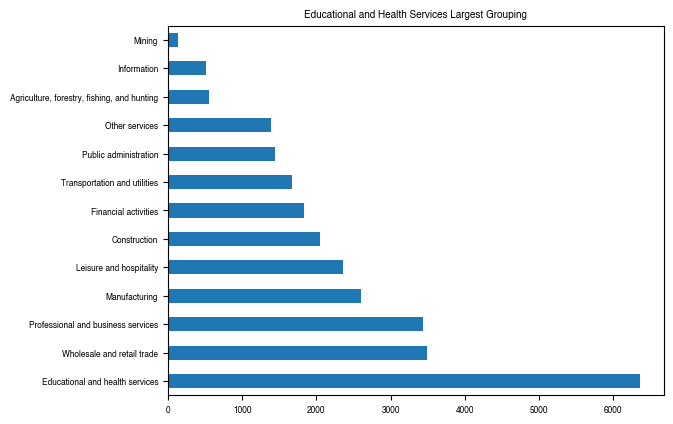

In [ ]:
industry_counts.plot.barh(title='Educational and Health Services Largest Grouping')

In [ ]:
# draw a grouped bar chart that shows industry proportion per region
df_bar = train.groupby(['region'])['industry'].value_counts(normalize=True).unstack()


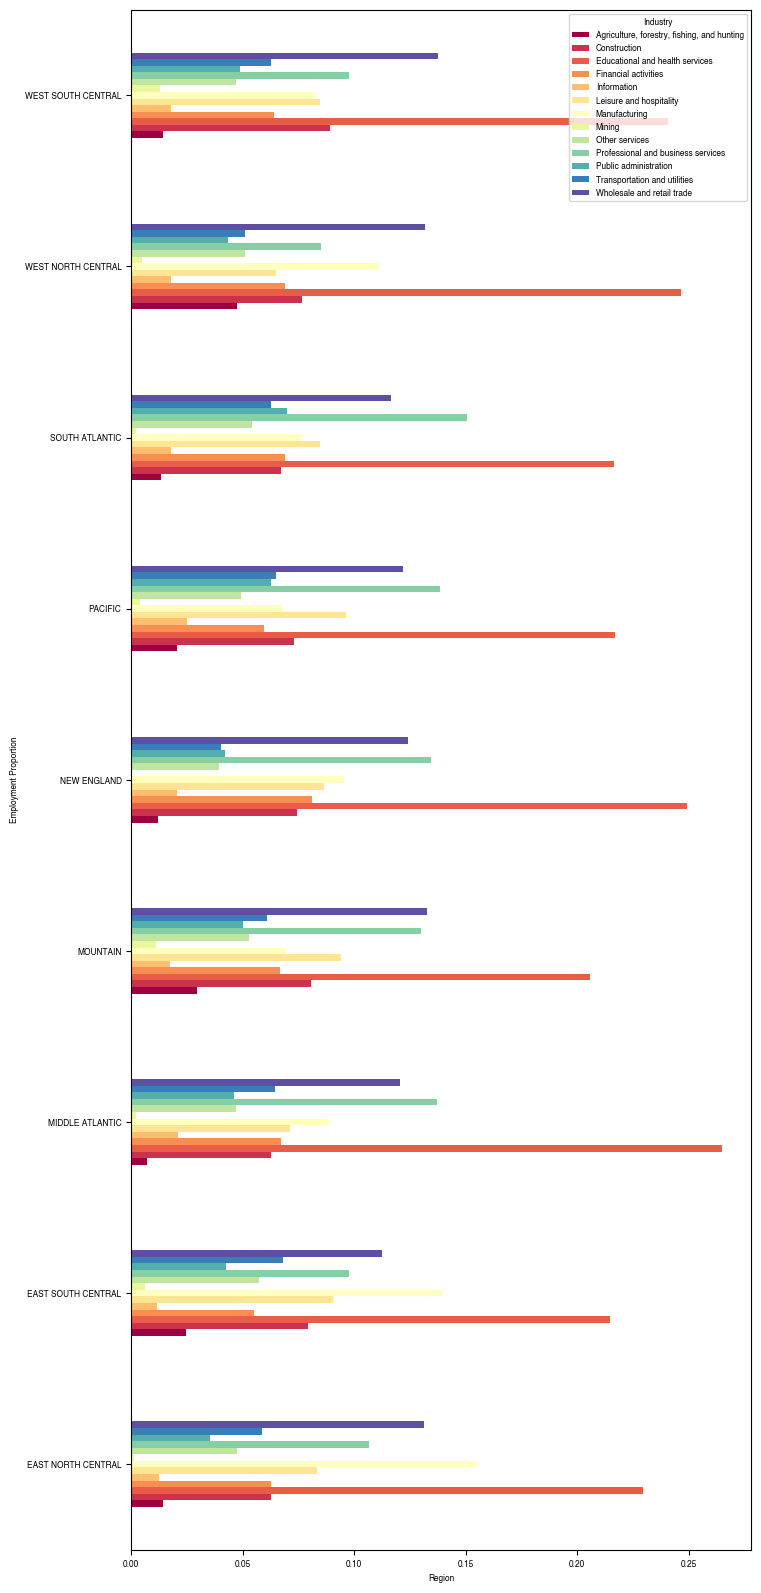

In [ ]:

# Draw bar plot --> add 2nd legend
fig, ax = plt.subplots(figsize=(8,20))
df_bar.plot(kind='barh', ax=ax, colormap='Spectral')
plt.legend(title='Industry')
plt.ylabel('Employment Proportion')
plt.xlabel('Region')
plt.show()

(5061, 30)


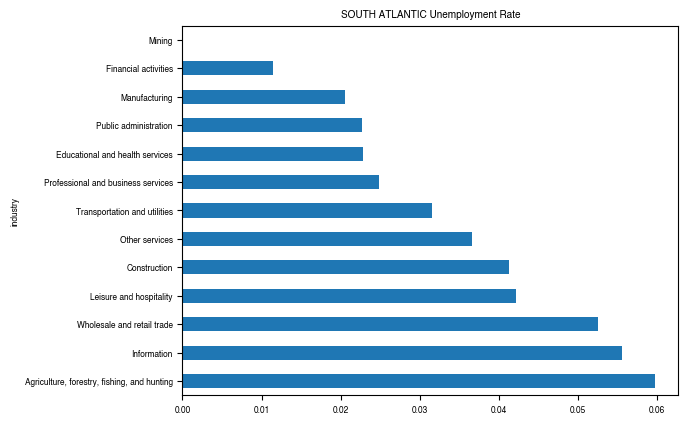

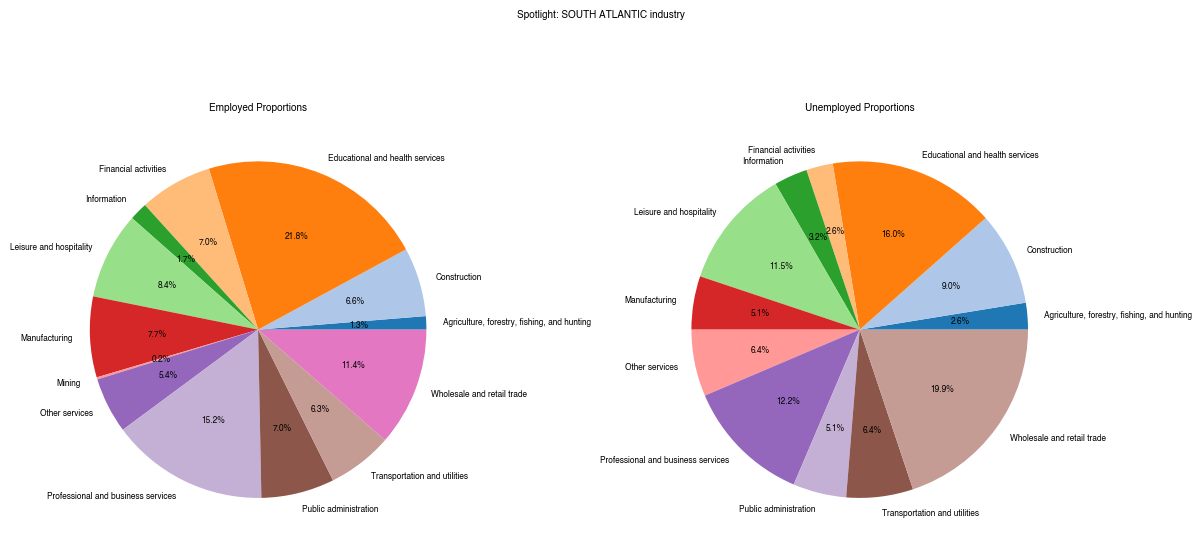

(4192, 30)


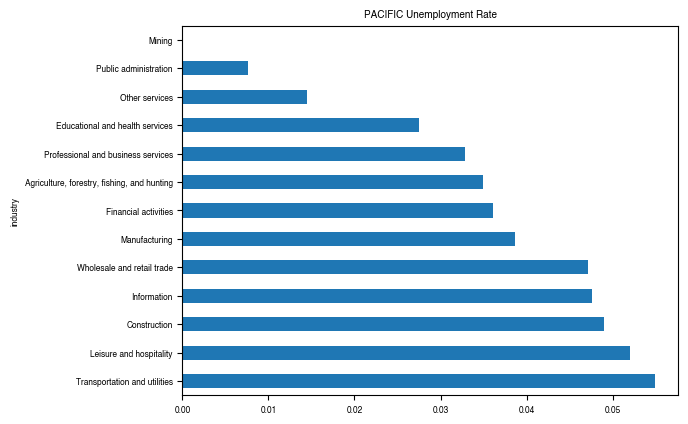

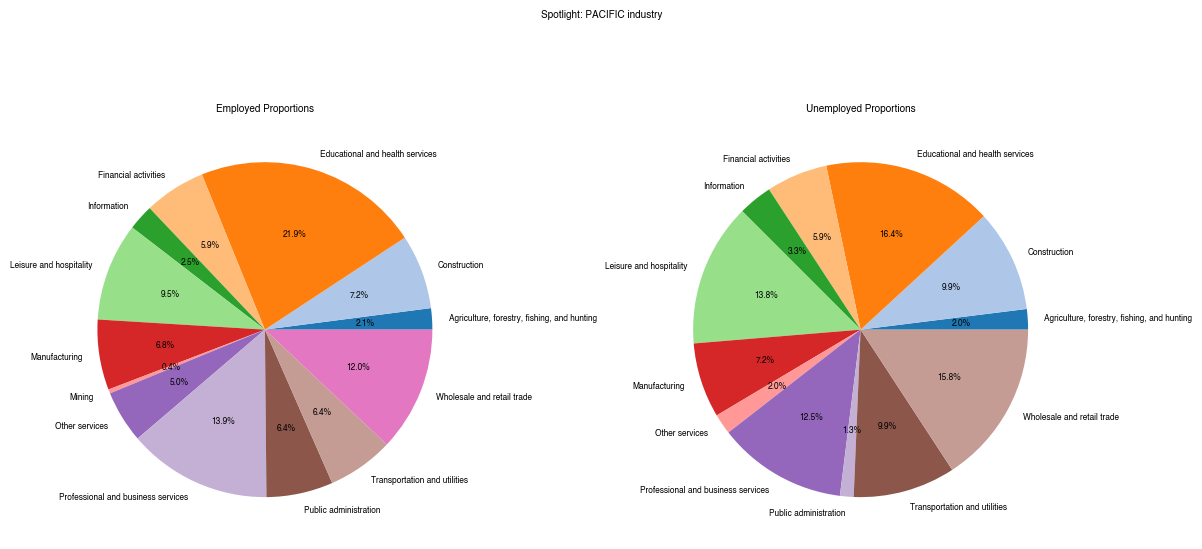

(3472, 30)


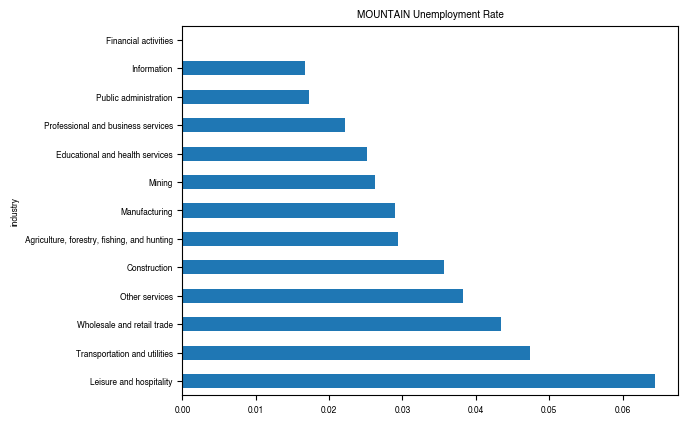

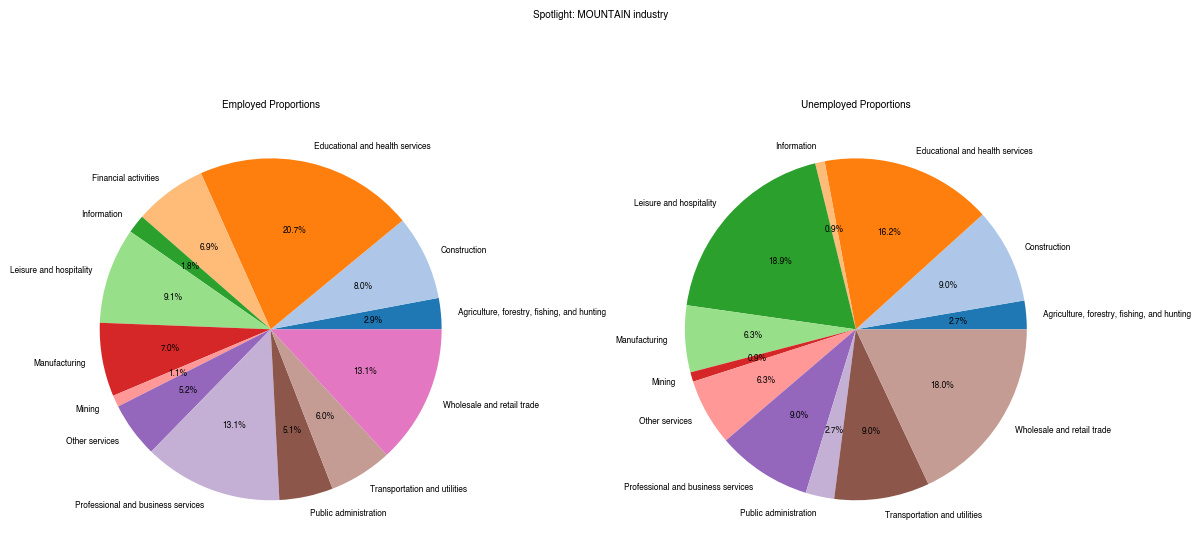

(3101, 30)


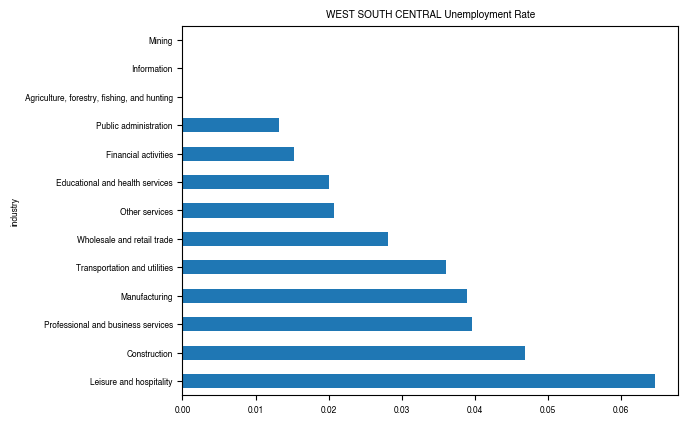

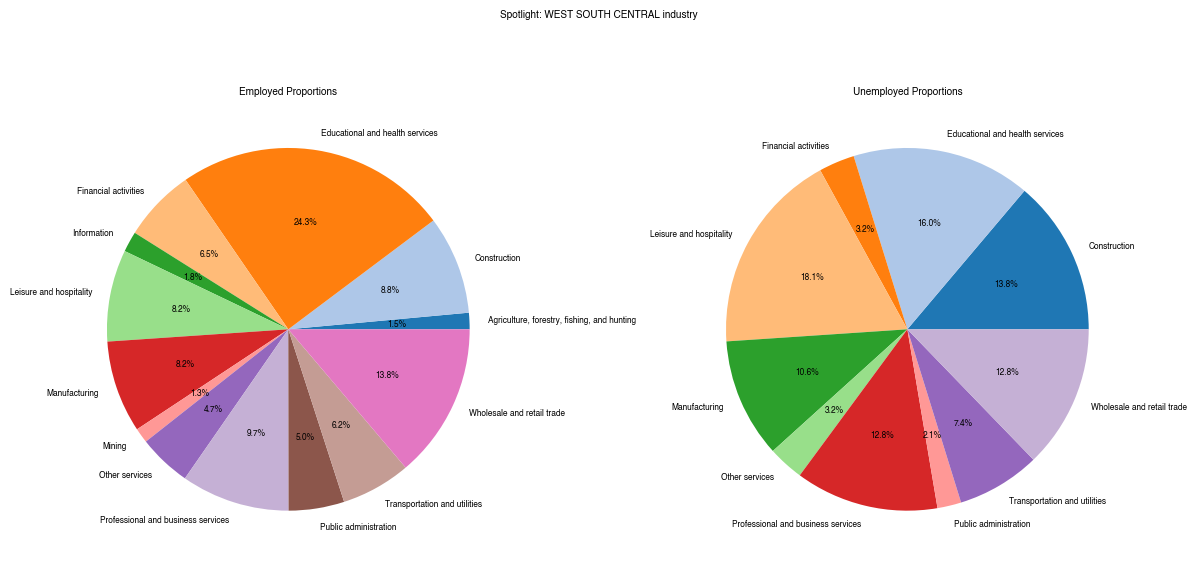

(2921, 30)


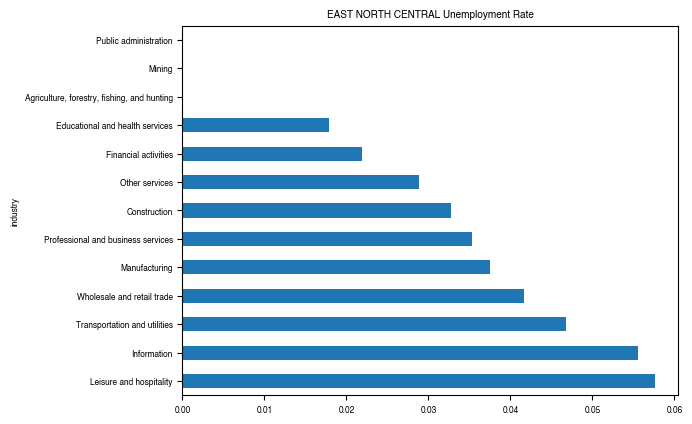

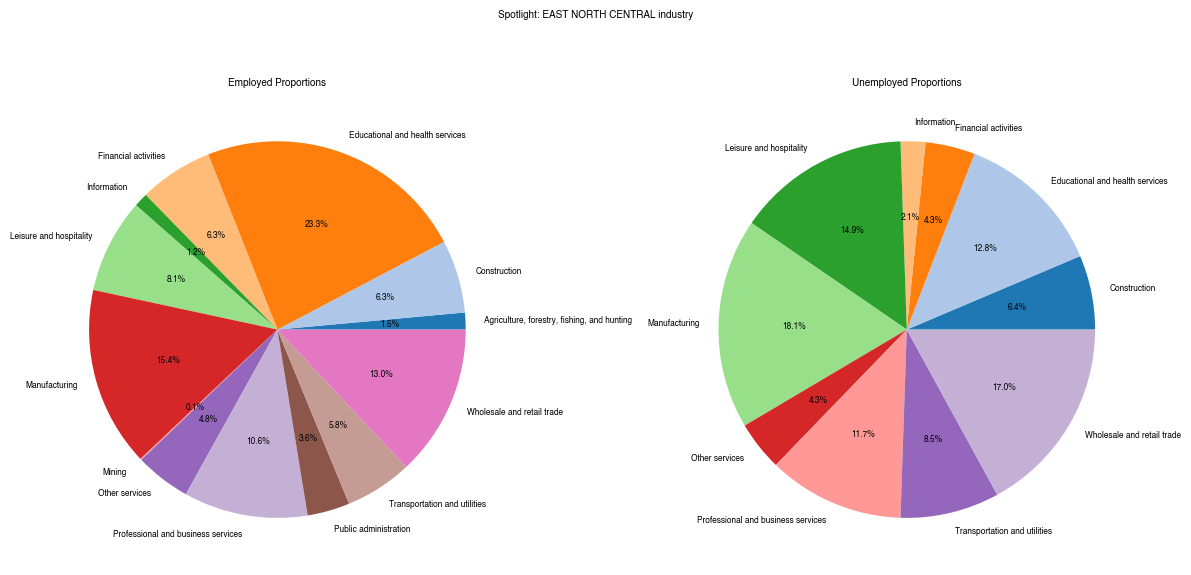

(2710, 30)


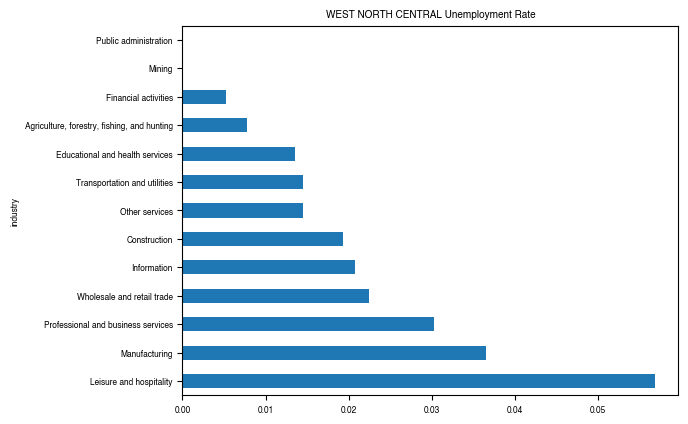

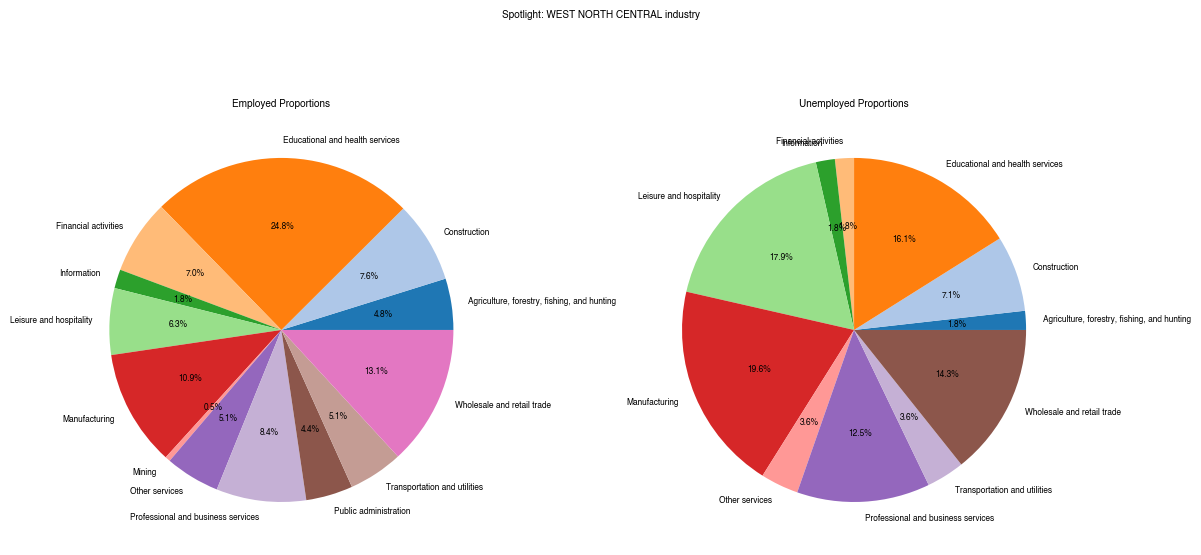

(2322, 30)


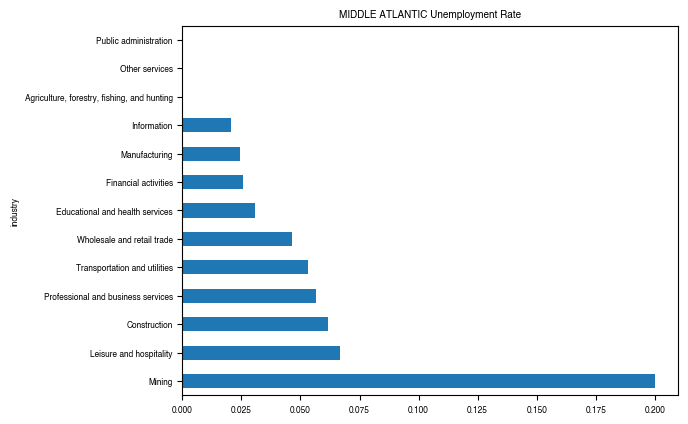

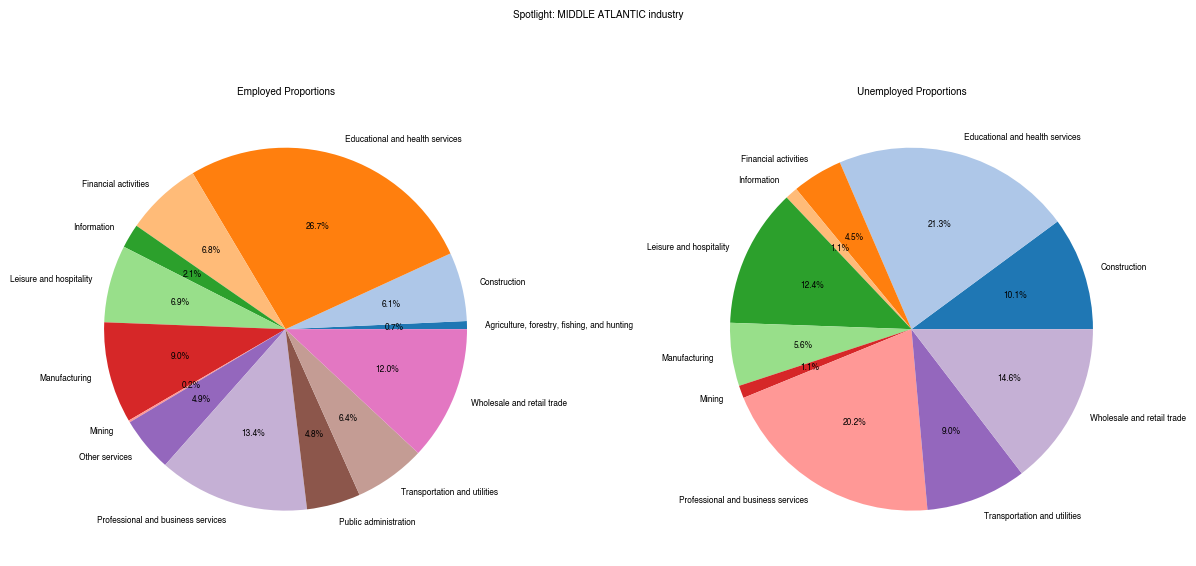

(2205, 30)


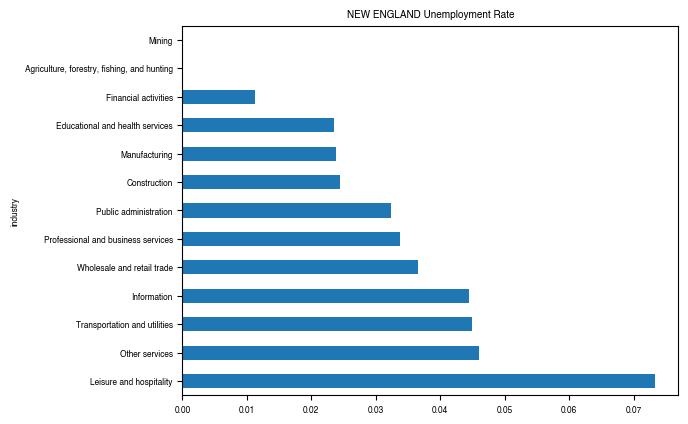

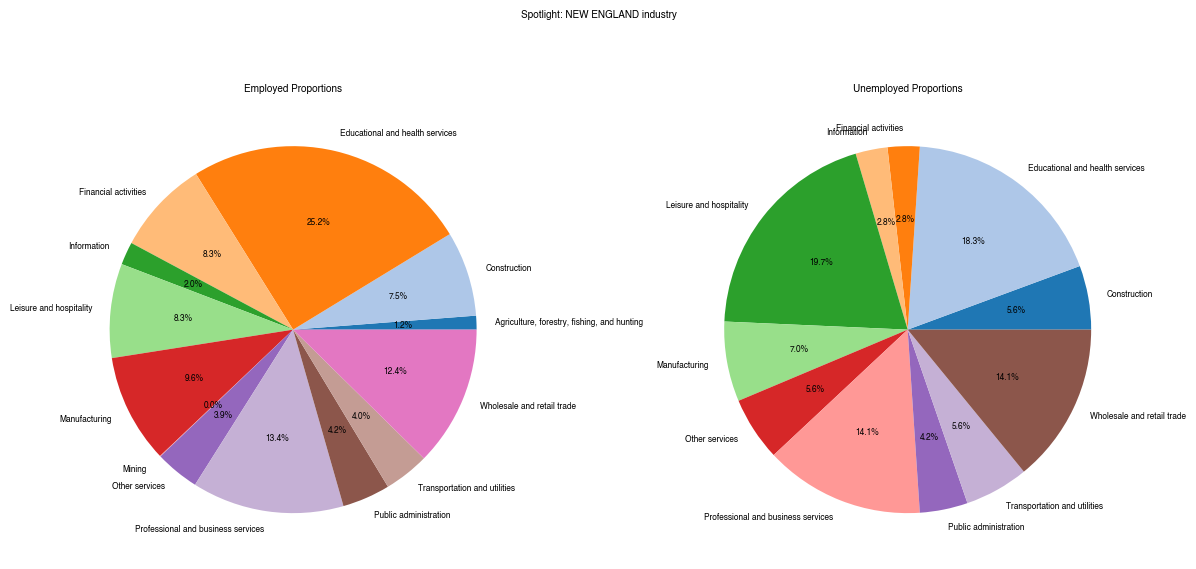

(1831, 30)


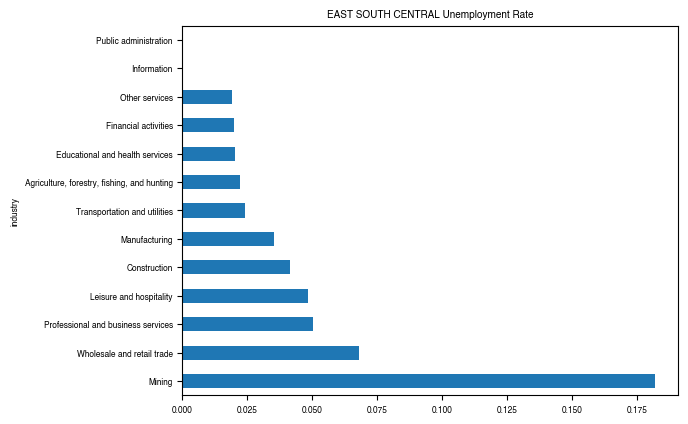

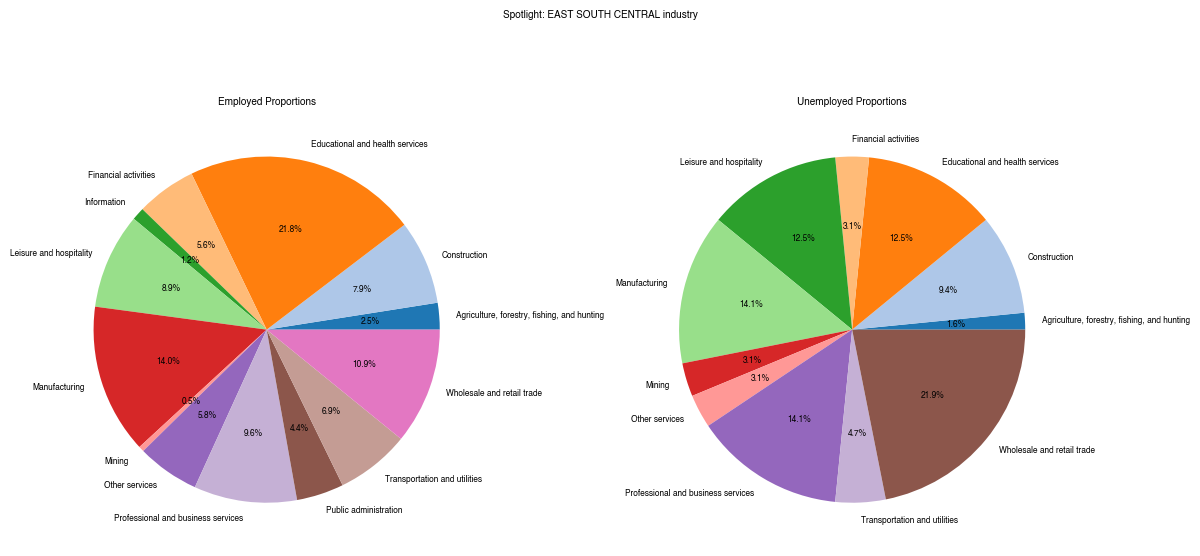

In [ ]:
for region in train.region.value_counts().index:
    region_subset = train[train.region == region]
    print(region_subset.shape)
    spotlight_region_viz(region_subset, 'industry', region)

In [ ]:
# Chart Displaying industry proportions by region
train.groupby(['region'])['industry'].value_counts(normalize=True).unstack().T

region,EAST NORTH CENTRAL,EAST SOUTH CENTRAL,MIDDLE ATLANTIC,MOUNTAIN,NEW ENGLAND,PACIFIC,SOUTH ATLANTIC,WEST NORTH CENTRAL,WEST SOUTH CENTRAL
industry,,,,,,,,,
"Agriculture, forestry, fishing, and hunting",0.014036,0.024577,0.006891,0.029378,0.011791,0.020515,0.013238,0.047601,0.014189
Construction,0.062650,0.079192,0.062877,0.080645,0.074376,0.072996,0.066983,0.076384,0.089326
Educational and health services,0.229374,0.214637,0.264858,0.205645,0.249433,0.216842,0.216360,0.246494,0.240890
Financial activities,0.062650,0.055161,0.067183,0.066532,0.081179,0.059399,0.068761,0.069004,0.063850
Information,0.012325,0.011469,0.021102,0.017281,0.020408,0.025048,0.017783,0.017712,0.017736
Leisure and hospitality,0.083191,0.090661,0.071059,0.093894,0.086621,0.096374,0.084568,0.064945,0.084811
Manufacturing,0.155084,0.139814,0.088717,0.069412,0.095238,0.067987,0.076665,0.111070,0.082876
Mining,0.001027,0.006008,0.002153,0.010945,0.000454,0.003817,0.001976,0.004797,0.012899
Other services,0.047586,0.057346,0.046942,0.052707,0.039456,0.049380,0.053942,0.050923,0.046759


#### Takeaways
* ag,for,fish, and hunt highest in east south central, mountain, and west north central.
* edu and health services min 20% in each region
* information (it) over 20% in only two regions (mid atl and pacific)
* manufacturing heavy in east north/south central


In [ ]:
1-train.employed.mean()

0.03188926838037032

In [ ]:
# unemployment rate for industries grouped by region
round(1-train.groupby(['region', 'industry'])['employed'].mean().unstack(), 3) 

industry,"Agriculture, forestry, fishing, and hunting",Construction,Educational and health services,Financial activities,Information,Leisure and hospitality,Manufacturing,Mining,Other services,Professional and business services,Public administration,Transportation and utilities,Wholesale and retail trade
region,,,,,,,,,,,,,
EAST NORTH CENTRAL,0.000,0.033,0.018,0.022,0.056,0.058,0.038,0.000,0.029,0.035,0.000,0.047,0.042
EAST SOUTH CENTRAL,0.022,0.041,0.020,0.020,0.000,0.048,0.035,0.182,0.019,0.050,0.000,0.024,0.068
MIDDLE ATLANTIC,0.000,0.062,0.031,0.026,0.020,0.067,0.024,0.200,0.000,0.057,0.000,0.053,0.046
MOUNTAIN,0.029,0.036,0.025,0.000,0.017,0.064,0.029,0.026,0.038,0.022,0.017,0.047,0.043
NEW ENGLAND,0.000,0.024,0.024,0.011,0.044,0.073,0.024,0.000,0.046,0.034,0.032,0.045,0.036
PACIFIC,0.035,0.049,0.028,0.036,0.048,0.052,0.039,0.000,0.014,0.033,0.008,0.055,0.047
SOUTH ATLANTIC,0.060,0.041,0.023,0.011,0.056,0.042,0.021,0.000,0.037,0.025,0.023,0.032,0.053
WEST NORTH CENTRAL,0.008,0.019,0.013,0.005,0.021,0.057,0.037,0.000,0.014,0.030,0.000,0.014,0.022
WEST SOUTH CENTRAL,0.000,0.047,0.020,0.015,0.000,0.065,0.039,0.000,0.021,0.040,0.013,0.036,0.028


In [ ]:
for region in train.region.value_counts().index:
    print(region)

SOUTH ATLANTIC
PACIFIC
MOUNTAIN
WEST SOUTH CENTRAL
EAST NORTH CENTRAL
WEST NORTH CENTRAL
MIDDLE ATLANTIC
NEW ENGLAND
EAST SOUTH CENTRAL


In [ ]:
round(1-train.groupby(['race', 'industry'])['employed'].mean().unstack(), 3)
# Takeaways
# * Construction with widely disproportionate unemployment rate
# * blacks with triple unemployment rate in professional and business services
# * mixed other with consistently high number across all industry



industry,"Agriculture, forestry, fishing, and hunting",Construction,Educational and health services,Financial activities,Information,Leisure and hospitality,Manufacturing,Mining,Other services,Professional and business services,Public administration,Transportation and utilities,Wholesale and retail trade
race,,,,,,,,,,,,,
AI/NA,0.000,0.000,0.041,0.000,0.000,0.065,0.056,0.333,0.000,0.042,0.000,0.067,0.171
HI/PI,NaN,0.000,0.062,0.091,0.000,0.000,0.000,0.000,0.000,0.000,0.167,0.083,0.040
asian,0.000,0.025,0.024,0.013,0.000,0.019,0.027,0.000,0.012,0.022,0.038,0.044,0.054
black,0.000,0.104,0.038,0.040,0.120,0.078,0.047,0.143,0.032,0.114,0.033,0.034,0.071
mixed_other,0.000,0.333,0.077,0.000,NaN,0.000,0.000,NaN,0.000,0.167,0.000,0.000,0.182
mixed_white,0.000,0.133,0.056,0.000,0.000,0.082,0.038,NaN,0.000,0.077,0.000,0.074,0.076
white,0.023,0.035,0.019,0.013,0.027,0.057,0.030,0.016,0.026,0.025,0.007,0.040,0.035


---
#### Takeaways - Industry
* Overall unemployment rate .031
* `Leisure and hospitality` with highest unemployment rate, highest jump in proportionality
* `Transportaion and utilities` with 2nd highest
* `Educational and Health Services` show greatest drop in portionality when moving from employed to unemployed 23% vs 17%
* Looking for sector/region combinations with more than double national employment rate
    * Ag in New England and South Atlantic
    * Leisure in mid atlantic, moutnain, new engalnd, 
    * mining in south atlantic
    * retail in east south central 
* information with highest unemployement rate (5.7%) in Pacific where it makes up highest percetange of workforce nationwide (2.5%)
* Construction with widely disproportionate unemployment rate
* blacks with triple unemployment rate in professional and business services
* mixed other with consistently high number across all industry
---

## Spotlight - Occupation



* **Question:** Which occupation shows the largest population proportion change between employed and unemployed?  
* **Answer:** Service occupations. These occupations also have the highest unemployment rate at 5%

#### Statistical Hypothesis
>* ${H_0}$: There is no relationship between occupation and employment status  
>* ${H_a}$: There is a relationship between occupation and employment status  
* ${\alpha}$: .05
* Result: Reject the null hyptothesis. **Test Code Below**

chi^2: 156.1434
p: 0.0000
degrees of freedom: 9
Reject null hypothesis
{'Construction and extraction': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 'Farming, fishing, and forestry': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274), 'Installation, maintenance, and repair': (1.0, 0.4980392156862745, 0.054901960784313725), 'Management, business, and financial': (1.0, 0.7333333333333333, 0.47058823529411764), 'Office and administrative support': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), 'Production': (0.596078431372549, 0.8745098039215686, 0.5411764705882353), 'Professional and related': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), 'Sales': (1.0, 0.596078431372549, 0.5882352941176471), 'Service': (0.5803921568627451, 0.403921568627451, 0.7411764705882353), 'Transportation and material moving': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589)}


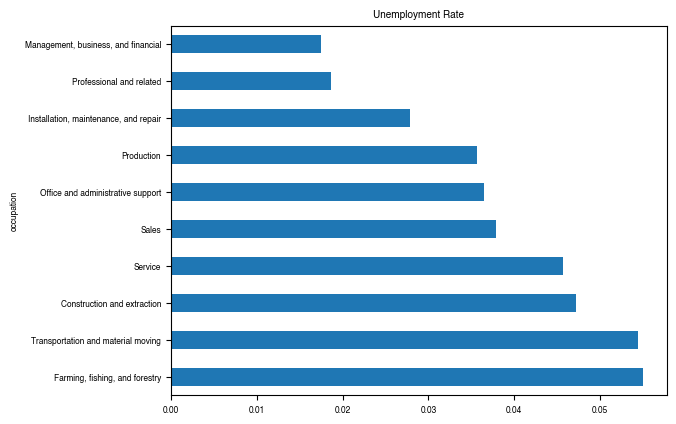

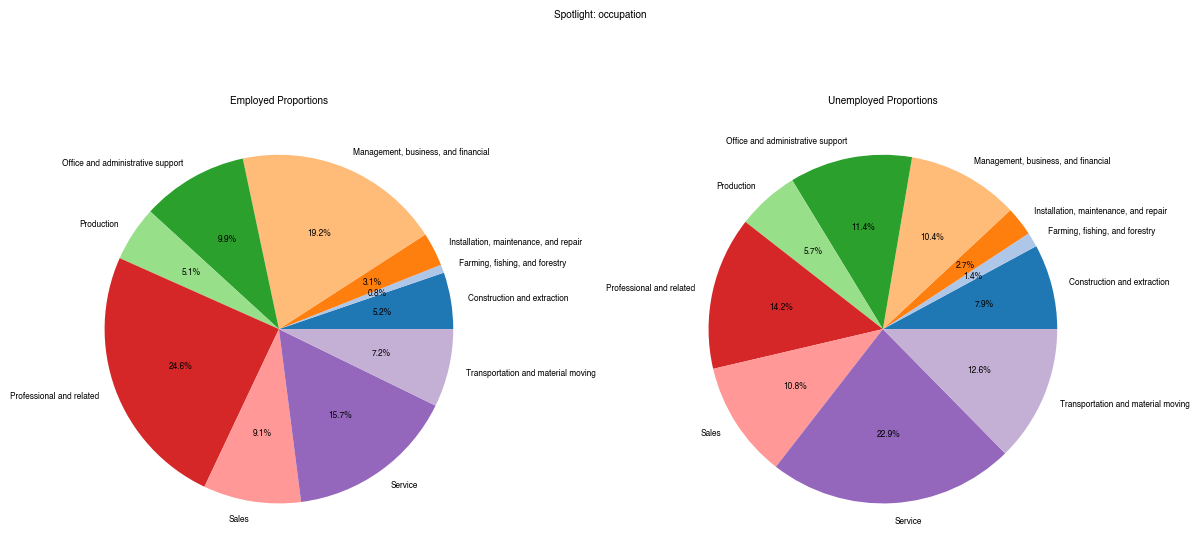

population_proportions             \
                                                    employed unemployed   
occupation                                                                
Farming, fishing, and forestry                         0.008      0.014   
Transportation and material moving                     0.072      0.126   
Construction and extraction                            0.052      0.079   
Service                                                0.157      0.229   
Sales                                                  0.091      0.108   
Office and administrative support                      0.099      0.114   
Production                                             0.051      0.057   
Installation, maintenance, and repair                  0.031      0.027   
Professional and related                               0.246      0.142   
Management, business, and financial                    0.192      0.104   

                                             unemployment_rate  
                                      change                    
occupation                                                      
Farming, fishing, and forestry         0.006             0.055  
Transportation and material moving     0.054             0.054  
Construction and extraction            0.026             0.047  
Service                                0.072             0.046  
Sales                                  0.018             0.038  
Office and administrative support      0.015             0.036  
Production                             0.006             0.036  
Installation, maintenance, and repair -0.004             0.028  
Professional and related              -0.104             0.019  
Management, business, and financial   -0.088             0.018

In [ ]:
spotlight_stats(train, 'occupation', 'occupation')

#### Statistical Testing

In [ ]:
#chi2

alpha = .05

crosstab = pd.crosstab(train['occupation'], train["employed"])

chi2, p, dof, expected = chi2_contingency(crosstab)

print('Crosstab\n')
print(crosstab.values)
print('---\nExpected\n')
print(f'{expected.astype(int)}')
print('---\n')
print(f'chi^2: {chi2:.4f}')
print(f'p: {p:.4f}')
print(f'degrees of freedom: {dof}')

if p < alpha :
    print('Reject null hypothesis')
else: 
    print('Fail to reject null hypothesis')


Crosstab

[[  70 1413]
 [  12  206]
 [  24  839]
 [  92 5169]
 [ 101 2664]
 [  51 1377]
 [ 126 6636]
 [  96 2440]
 [ 203 4236]
 [ 112 1948]]
---
Expected

[[  47 1435]
 [   6  211]
 [  27  835]
 [ 167 5093]
 [  88 2676]
 [  45 1382]
 [ 215 6546]
 [  80 2455]
 [ 141 4297]
 [  65 1994]]
---

chi^2: 156.1434
p: 0.0000
degrees of freedom: 9
Reject null hypothesis


### October Questions
* Effect of Age
* Median Income
* Gender Make Up
* Marital Status
* Education


In [ ]:
# average age of data set
train.age.mean()

43.31871292468093

In [ ]:
#### Effect of Age
# management, business, and financial with highest mean age
# service is youngest
train.groupby('occupation')['age'].mean().sort_values()

occupation
Service                                  40.053390
Sales                                    41.718454
Construction and extraction              42.198921
Installation, maintenance, and repair    42.412514
Transportation and material moving       42.735437
Farming, fishing, and forestry           42.802752
Production                               43.224790
Professional and related                 43.785566
Office and administrative support        43.932369
Management, business, and financial      46.662232
Name: age, dtype: float64

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27815 entries, 2853 to 29968
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   housing_type                27815 non-null  object  
 1   household_num               27815 non-null  float64 
 2   family_income               27815 non-null  category
 3   household_type              27815 non-null  object  
 4   own_bus_or_farm             27815 non-null  int64   
 5   region                      27815 non-null  object  
 6   state                       27815 non-null  object  
 7   metropolitan                27815 non-null  object  
 8   metro_area_size             27815 non-null  float64 
 9   age                         27815 non-null  float64 
 10  marital_status              27815 non-null  object  
 11  is_male                     27815 non-null  int64   
 12  veteran                     27815 non-null  int64   
 13  education    

In [ ]:
####  Family Income
# Over 30% of both professional and management occupation households make 150,000 or More
# Over 40% of farming and service occupation households make less than 50,000
# less than 10% of construction occupation households make more than 150,000
train.groupby('occupation')['family_income'].value_counts(normalize=True).unstack()


,"0 TO 49,999","50,000 to 74,999","75,000 to 99,999","100,000 to 149,999","150,000 or More"
occupation,,,,,
Construction and extraction,0.354686,0.236008,0.153742,0.157788,0.097775
"Farming, fishing, and forestry",0.454128,0.229358,0.110092,0.100917,0.105505
"Installation, maintenance, and repair",0.231750,0.229432,0.181924,0.208575,0.148320
"Management, business, and financial",0.118609,0.125642,0.144649,0.224102,0.386999
Office and administrative support,0.274503,0.208318,0.169620,0.188065,0.159494
Production,0.326331,0.250000,0.165266,0.157563,0.100840
Professional and related,0.134132,0.151287,0.144780,0.230109,0.339692
Sales,0.260252,0.183360,0.134464,0.185726,0.236199
Service,0.409101,0.205226,0.129759,0.131336,0.124578


In [ ]:
####Gender Make Up
# production occupations sho 16% gap in proportionality with 43% of women in the occupation making less than 50k. similiar difference in sales (12%)
# in farming there is a 10% proportionality difference in the 100k to 149k range (11%) be similar numbers elsewhere
# next iteration explore absolute value of difference 
train.groupby(['occupation','is_male' ])['family_income'].value_counts(normalize=True).unstack()

0 TO 49,999  50,000 to 74,999  \
occupation                            is_male                                  
Construction and extraction           0           0.383333          0.333333   
                                      1           0.353479          0.231904   
Farming, fishing, and forestry        0           0.532258          0.161290   
                                      1           0.423077          0.256410   
Installation, maintenance, and repair 0           0.410256          0.230769   
                                      1           0.223301          0.229369   
Management, business, and financial   0           0.117429          0.133086   
                                      1           0.119619          0.119266   
Office and administrative support     0           0.280258          0.204365   
                                      1           0.259012          0.218959   
Production                            0           0.421176          0.204706   
                                      1           0.286142          0.269192   
Professional and related              0           0.151802          0.158702   
                                      1           0.109863          0.141102   
Sales                                 0           0.316327          0.191523   
                                      1           0.203645          0.175119   
Service                               0           0.430550          0.200462   
                                      1           0.378804          0.211957   
Transportation and material moving    0           0.431072          0.210066   
                                      1           0.336245          0.225203   

                                               75,000 to 99,999  \
occupation                            is_male                     
Construction and extraction           0                0.100000   
                                      1                0.156008   
Farming, fishing, and forestry        0                0.161290   
                                      1                0.089744   
Installation, maintenance, and repair 0                0.128205   
                                      1                0.184466   
Management, business, and financial   0                0.144211   
                                      1                0.145025   
Office and administrative support     0                0.174107   
                                      1                0.157543   
Production                            0                0.129412   
                                      1                0.180459   
Professional and related              0                0.148991   
                                      1                0.138996   
Sales                                 0                0.122449   
                                      1                0.146593   
Service                               0                0.130435   
                                      1                0.128804   
Transportation and material moving    0                0.140044   
                                      1                0.140986   

                                               100,000 to 149,999  \
occupation                            is_male                       
Construction and extraction           0                  0.116667   
                                      1                  0.159522   
Farming, fishing, and forestry        0                  0.032258   
                                      1                  0.128205   
Installation, maintenance, and repair 0                  0.128205   
                                      1                  0.212379   
Management, business, and financial   0                  0.234446   
                                      1                  0.215243   
Office and administrative support     0                  0.188492   
                                      1             

In [ ]:
# Education
# ONLY management, and profession occupations have less that 49% with only high school /ged level education. the same with more 10% post_grad
# construction, farming, service occupations all hve greter than 15% with no high school


In [ ]:
train.groupby(['occupation' ])['education'].value_counts(normalize=True).unstack()

,no_high_school,high_school_ged,associates,bachelor,post_grad
occupation,,,,,
Construction and extraction,0.181389,0.623061,0.106541,0.072825,0.016183
"Farming, fishing, and forestry",0.252294,0.550459,0.064220,0.100917,0.032110
"Installation, maintenance, and repair",0.062572,0.623407,0.194670,0.100811,0.018540
"Management, business, and financial",0.018628,0.272572,0.082684,0.396312,0.229804
Office and administrative support,0.037251,0.533816,0.144304,0.233635,0.050995
Production,0.116947,0.658964,0.108543,0.091737,0.023810
Professional and related,0.009613,0.150104,0.095682,0.368382,0.376220
Sales,0.084385,0.490931,0.098580,0.268139,0.057965
Service,0.158369,0.565443,0.117819,0.129308,0.029061


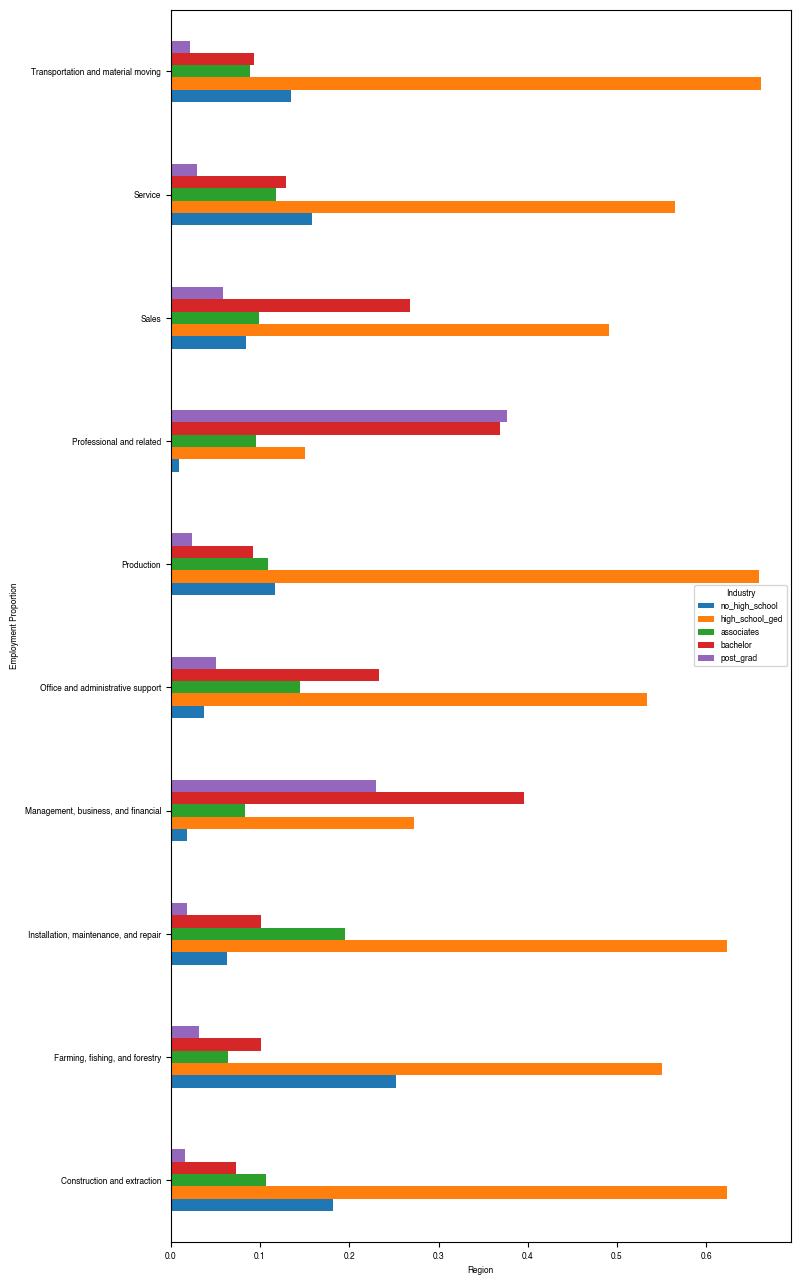

In [ ]:

df_bar = train.groupby(['occupation' ])['education'].value_counts(normalize=True).unstack()

fig, ax = plt.subplots(figsize=(8,16))
df_bar.plot(kind='barh', ax=ax)
plt.legend(title='Industry')
plt.ylabel('Employment Proportion')
plt.xlabel('Region')
plt.show()

---
### Takeways
* Farming fishing and forestry at the top
* service occupations, transportation and material movie tied for 2nd
* service occupations highest change in proportionality
* management, business, and financial with highest mean age
* service is youngest
* Over 30% of both professional and management occupation households make 150,000 or More
* Over 40% of farming and service occupation households make less than 50,000
* less than 10% of construction occupation households make more than 150,000
* ONLY management, and profession occupations have less that 49% with only high school /ged level education. the same with more 10% post_grad
* construction, farming, service occupations all have greter than 15% with no high school
---

## Spotlight - Marital Status


* **Question:** Which marital status disposition shows the largest population proportion change between employed and unemployed?  
* **Answer:** Single individuals make up a larger share of the unemployed and have an unemployment rate of 5%.

#### Statistical Hypothesis
>* ${H_0}$: There is no relationship between `marital_status` and `employment` status   
>* ${H_a}$: There is a relationship between `marital_status` and `employment` status  
* ${\alpha}$: .05  
* Result: There is enough evidence to reject our null hypothesis. **Test code below**

chi^2: 199.9152
p: 0.0000
degrees of freedom: 1
Reject null hypothesis
{'married': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 'single': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274)}


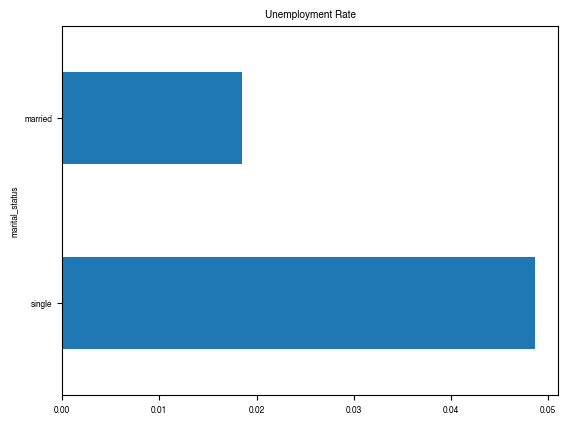

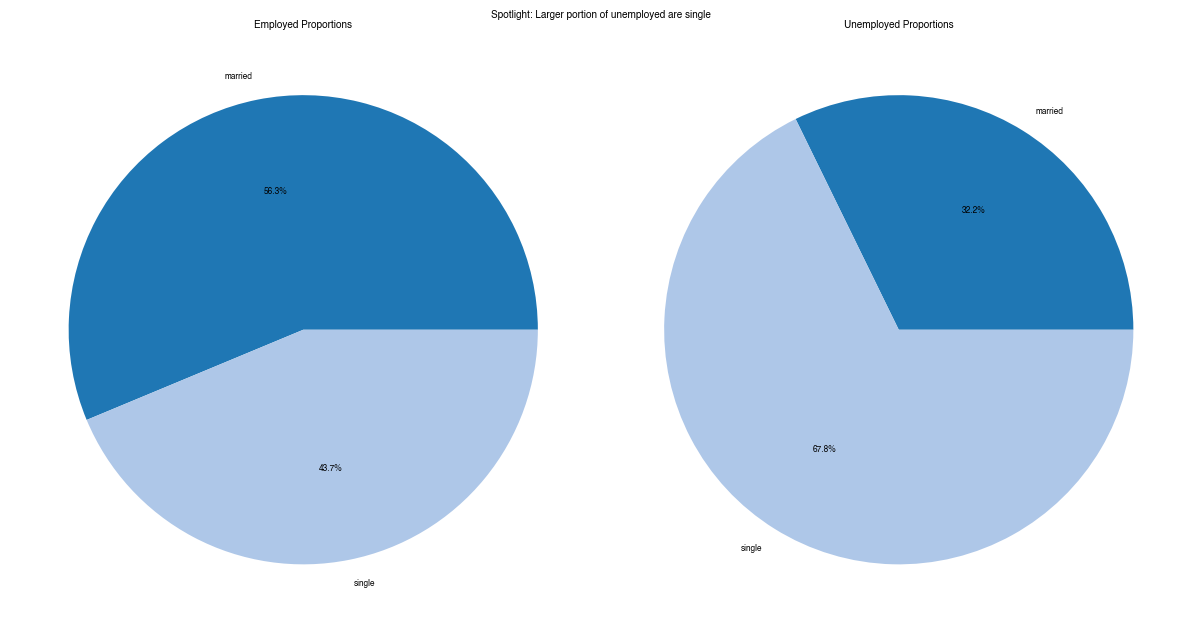

population_proportions                   unemployment_rate
                             employed unemployed change                  
marital_status                                                           
single                          0.437      0.678   0.24             0.049
married                         0.563      0.322  -0.24             0.018

In [ ]:
spotlight_stats(train, 'marital_status', 'Larger portion of unemployed are single')

#### Statistical Testing

In [ ]:
#chi2

alpha = .05

crosstab = pd.crosstab(train['marital_status'], train["employed"])

chi2, p, dof, expected = chi2_contingency(crosstab)

print('Crosstab\n')
print(crosstab.values)
print('---\nExpected\n')
print(f'{expected.astype(int)}')
print('---\n')
print(f'chi^2: {chi2:.4f}')
print(f'p: {p:.4f}')
print(f'degrees of freedom: {dof}')

if p < alpha :
    print('Reject null hypothesis')
else: 
    print('Fail to reject null hypothesis')


Crosstab

[[  286 15155]
 [  601 11773]]
---
Expected

[[  492 14948]
 [  394 11979]]
---

chi^2: 199.9152
p: 0.0000
degrees of freedom: 1
Reject null hypothesis


### October Questions 
* Effect on Income
* Relationship with professional certification

In [ ]:
train.marital_status.value_counts()

married    15441
single     12374
Name: marital_status, dtype: int64

In [ ]:
married = train[train.marital_status == 'married']

In [ ]:
single = train[train.marital_status != 'married']

In [ ]:
married.family_income.value_counts(normalize=True)

150,000 or More       0.304449
100,000 to 149,999    0.222783
0 TO 49,999           0.162943
50,000 to 74,999      0.157762
75,000 to 99,999      0.152063
Name: family_income, dtype: float64

In [ ]:
single.family_income.value_counts(normalize=True)

0 TO 49,999           0.345644
50,000 to 74,999      0.211088
150,000 or More       0.153952
100,000 to 149,999    0.150881
75,000 to 99,999      0.138435
Name: family_income, dtype: float64

In [ ]:
train[train.professional_certification == 1].age.mean()

45.48966613672496

In [ ]:
married.age.mean()

47.62832718088207

In [ ]:
single.age.mean()

37.940924519153064

In [ ]:
train.groupby('marital_status')['professional_certification'].mean()

marital_status
married    0.289165
single     0.198319
Name: professional_certification, dtype: float64

---
### Takeaways
* `single` individuals with highest unemployment rate, 5% vs 2%
* `married` make up larger portion of data 
* proportinality difference is more than a simple doubling of income.
    * 34% of single make less than 50k but over 50% of married have household income more than 100k
* 28% of married have professional certification, 19% of single individuals
    * Can possibly be explained by average single person being 8 years younger than the average age of those with professional certifications
* Next Steps
    * should examine age by bins later
---

## Spotlight - Race


* **Question:** Which industry shows the largest population proportion change between employed and unemployed?  
* **Answer:** Indivduals identifying as White show the largest population proportion change with a drop of nearly 10% when comparing employed vs unemployed. Those identifying as mixed race other than white, and Indigenous have the highest unemployed rates at 8% and 7% respectively. 

#### Statistical Hypothesis
>* ${H_0}$: There is no relationship between `race` and `employment` status   
>* ${H_a}$: There is a relationship between `race` and `employment` status   
* ${\alpha}$: .05  
* Result: There is enough evidence to reject our null hypothesis. **Test code below**

chi^2: 92.7950
p: 0.0000
degrees of freedom: 6
Reject null hypothesis
{'AI/NA': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 'HI/PI': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274), 'asian': (1.0, 0.4980392156862745, 0.054901960784313725), 'black': (1.0, 0.7333333333333333, 0.47058823529411764), 'mixed_other': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), 'mixed_white': (0.596078431372549, 0.8745098039215686, 0.5411764705882353), 'white': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)}


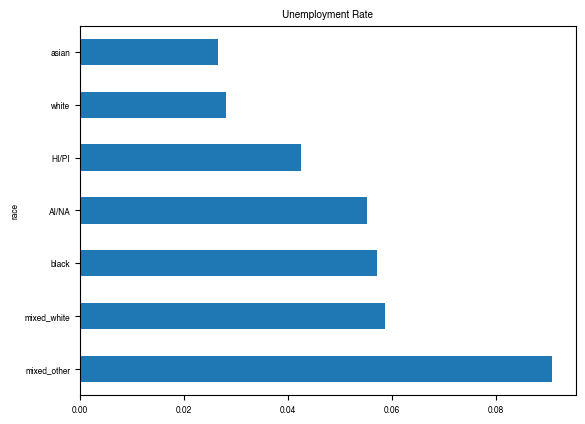

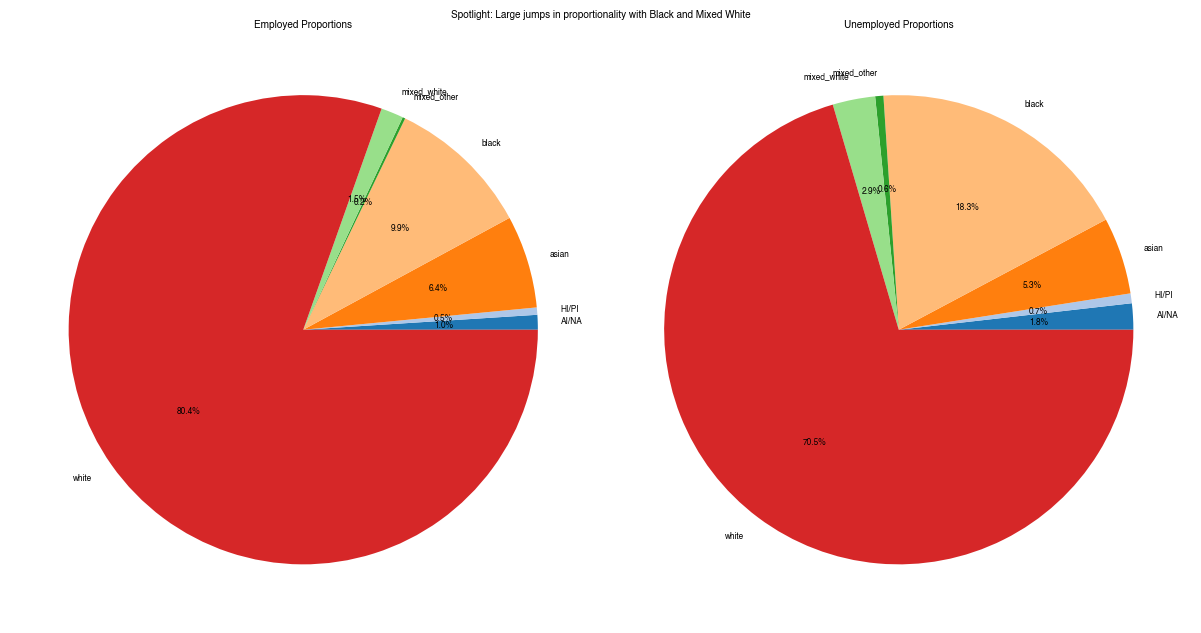

population_proportions                   unemployment_rate
                          employed unemployed change                  
race                                                                  
mixed_other                  0.002      0.006  0.004             0.091
mixed_white                  0.015      0.029  0.014             0.059
black                        0.099      0.183  0.083             0.057
AI/NA                        0.010      0.018  0.008             0.055
HI/PI                        0.005      0.007  0.002             0.043
white                        0.804      0.705 -0.100             0.028
asian                        0.064      0.053 -0.011             0.027

In [ ]:
spotlight_stats(train, 'race', 'Large jumps in proportionality with Black and Mixed White')

#### Statistical Testing

In [ ]:
#chi2

alpha = .05

crosstab = pd.crosstab(train['race'], train["employed"])

chi2, p, dof, expected = chi2_contingency(crosstab)

print('Crosstab\n')
print(crosstab.values)
print('---\nExpected\n')
print(f'{expected.astype(int)}')
print('---\n')
print(f'chi^2: {chi2:.4f}')
print(f'p: {p:.4f}')
print(f'degrees of freedom: {dof}')

if p < alpha :
    print('Reject null hypothesis')
else: 
    print('Fail to reject null hypothesis')


Crosstab

[[   16   274]
 [    6   135]
 [   47  1721]
 [  162  2676]
 [    5    50]
 [   26   416]
 [  625 21656]]
---
Expected

[[    9   280]
 [    4   136]
 [   56  1711]
 [   90  2747]
 [    1    53]
 [   14   427]
 [  710 21570]]
---

chi^2: 92.7950
p: 0.0000
degrees of freedom: 6
Reject null hypothesis


### October Questions
* Income
* Education
* Region
* Full or Part Time 

In [ ]:
train.groupby(['race'])['family_income'].value_counts(normalize=True).unstack()

,"0 TO 49,999","50,000 to 74,999","75,000 to 99,999","100,000 to 149,999","150,000 or More"
race,,,,,
AI/NA,0.386207,0.203448,0.127586,0.172414,0.110345
HI/PI,0.262411,0.205674,0.134752,0.226950,0.170213
asian,0.171946,0.132353,0.112557,0.184389,0.398756
black,0.372445,0.207541,0.140240,0.125440,0.154334
mixed_other,0.309091,0.218182,0.127273,0.181818,0.163636
mixed_white,0.278281,0.190045,0.199095,0.160633,0.171946
white,0.230824,0.181365,0.148692,0.200260,0.238858


In [ ]:
train.groupby(['race'])['education'].value_counts(normalize=True).unstack()

,no_high_school,high_school_ged,associates,bachelor,post_grad
race,,,,,
AI/NA,0.117241,0.527586,0.155172,0.134483,0.065517
HI/PI,0.056738,0.560284,0.099291,0.205674,0.078014
asian,0.043552,0.245475,0.054299,0.354072,0.302602
black,0.065891,0.502114,0.117336,0.197322,0.117336
mixed_other,0.018182,0.654545,0.018182,0.218182,0.090909
mixed_white,0.110860,0.466063,0.106335,0.208145,0.108597
white,0.074054,0.414389,0.107580,0.253893,0.150083


In [ ]:
train.groupby(['region'])['race'].value_counts(normalize=True).unstack()

race,AI/NA,HI/PI,asian,black,mixed_other,mixed_white,white
region,,,,,,,
EAST NORTH CENTRAL,0.003423,0.002054,0.046559,0.090038,NaN,0.014379,0.843547
EAST SOUTH CENTRAL,0.003823,0.001638,0.016931,0.207537,0.001092,0.008738,0.760240
MIDDLE ATLANTIC,0.002584,0.001723,0.106804,0.118002,0.003015,0.007752,0.760121
MOUNTAIN,0.021313,0.006336,0.031682,0.025058,0.000576,0.015265,0.899770
NEW ENGLAND,0.003628,0.001361,0.047619,0.058050,NaN,0.014059,0.875283
PACIFIC,0.018607,0.020038,0.168655,0.040076,0.007395,0.031489,0.713740
SOUTH ATLANTIC,0.005137,0.001976,0.043865,0.192057,0.001383,0.012843,0.742739
WEST NORTH CENTRAL,0.009594,0.001476,0.027306,0.046125,0.000369,0.013653,0.901476
WEST SOUTH CENTRAL,0.017736,0.001612,0.043534,0.142212,0.001612,0.015479,0.777814


In [ ]:
train.groupby(['race'])['ft_or_pt'].value_counts(normalize=True).unstack()

ft_or_pt,full_time,part_time
race,,
AI/NA,0.834483,0.165517
HI/PI,0.886525,0.113475
asian,0.849548,0.150452
black,0.855180,0.144820
mixed_other,0.745455,0.254545
mixed_white,0.789593,0.210407
white,0.825232,0.174768


In [ ]:
train.ft_or_pt.value_counts(normalize=True)

full_time    0.829516
part_time    0.170484
Name: ft_or_pt, dtype: float64

---
### Takeways
* Mixed raced top of unemployed
* indeginous, black, and hi/pi among tops in unemployment
* black with highest change in proportionality 
* Income
    * Indigenous with populations with highest proportion under 50k --> 44%
    * Asian with highest proportion above 150k --> 38%
* Education
    * Majority Asian have bachelor's or greater, only racial group that holds true for
* Region 
    * Not much interesting to take away. Most regions above 75% White with lowest proportions in South Atlantic and Pacific
    * The losses there primarily come from gains to Black (south atlantic) and Asian (pacific)
    * Pacfic with largest proportion of mixed race individuals
* Full or Part Time 
    * only mixed race show positive deviations in proportion
---

## Spotlight - Professional Certification

* **Question:** What is the effect of having a professional certification?  
* **Answer:** Leisure and Hospitality. This industry also has the highest unemployment rate at 6%

#### Statistical Hypothesis
* ${H_0}$: There is no relationship between having a `professional_certification` and `employment`  
* ${H_a}$: There is a relationship between having a `professional_certification` and `employment`    
>* ${\alpha}$: .05
>* Result: There is enough evidence to reject our null hypothesis. **Test code below**

chi^2: 103.9291
p: 0.0000
degrees of freedom: 1
Reject null hypothesis
{0: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 1: (0.6823529411764706, 0.7803921568627451, 0.9098039215686274)}


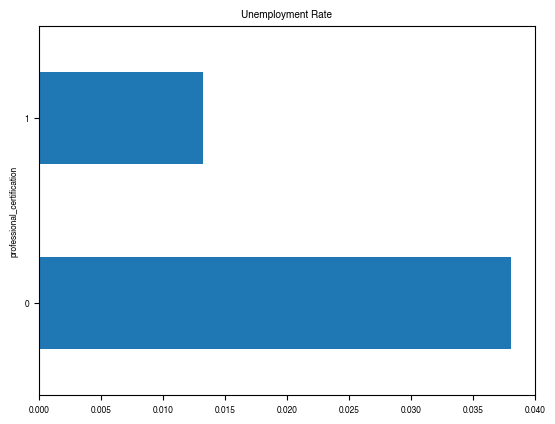

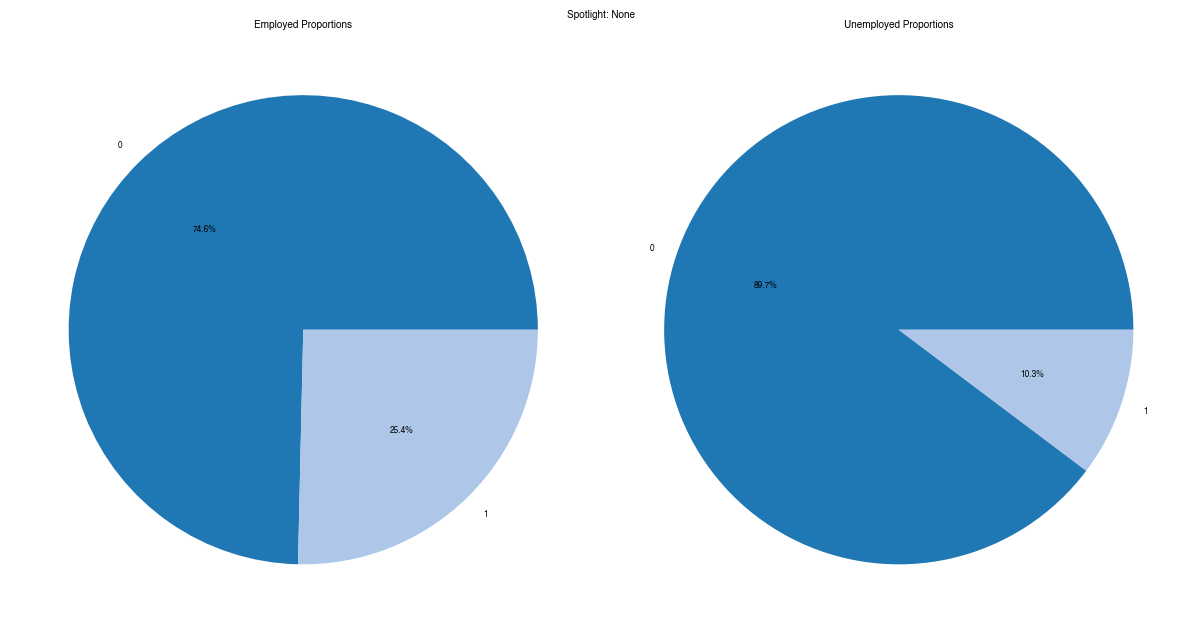

population_proportions                    \
                                         employed unemployed change   
professional_certification                                            
0                                           0.746      0.897  0.151   
1                                           0.254      0.103 -0.151   

                           unemployment_rate  
                                              
professional_certification                    
0                                      0.038  
1                                      0.013

In [ ]:
spotlight_stats(train, 'professional_certification')

#### Statistical Testing

In [ ]:
#chi2

alpha = .05

crosstab = pd.crosstab(train['professional_certification'], train["employed"])

chi2, p, dof, expected = chi2_contingency(crosstab)

print('Crosstab\n')
print(crosstab.values)
print('---\nExpected\n')
print(f'{expected.astype(int)}')
print('---\n')
print(f'chi^2: {chi2:.4f}')
print(f'p: {p:.4f}')
print(f'degrees of freedom: {dof}')

if p < alpha :
    print('Reject null hypothesis')
else: 
    print('Fail to reject null hypothesis')


Crosstab

[[  796 20100]
 [   91  6828]]
---
Expected

[[  666 20229]
 [  220  6698]]
---

chi^2: 103.9291
p: 0.0000
degrees of freedom: 1
Reject null hypothesis


### October Questions
* Effect of Education
* Race 
* Occupation


In [ ]:
train.groupby(['professional_certification'])['education'].value_counts(normalize=True).unstack()

,no_high_school,high_school_ged,associates,bachelor,post_grad
professional_certification,,,,,
0,0.089826,0.466453,0.090974,0.244975,0.107772
1,0.018644,0.262899,0.149155,0.274028,0.295274


In [ ]:
train.groupby(['professional_certification'])['race'].value_counts(normalize=True).unstack()

race,AI/NA,HI/PI,asian,black,mixed_other,mixed_white,white
professional_certification,,,,,,,
0,0.011007,0.005408,0.068147,0.106336,0.002106,0.016127,0.790869
1,0.008672,0.004047,0.049718,0.089030,0.001590,0.015176,0.831768


In [ ]:
train.groupby(['professional_certification'])['occupation'].value_counts(normalize=True).unstack()

occupation,Construction and extraction,"Farming, fishing, and forestry","Installation, maintenance, and repair","Management, business, and financial",Office and administrative support,Production,Professional and related,Sales,Service,Transportation and material moving
professional_certification,,,,,,,,,,
0,0.058767,0.009428,0.031968,0.196353,0.119305,0.062500,0.177020,0.098823,0.165725,0.080111
1,0.036855,0.003035,0.028183,0.167365,0.039312,0.017633,0.442694,0.068073,0.141061,0.055788


---
#### Takeways
* 4x the unemployment rate for those without a professional_certification
* Effect of Education
    * those with professsional certification more likely to have completed bachelor's and above. largest gains in post_grad area. 19% greater proportionality. Much less likely to have no high school diploma/ged 
* Race
    * consistent proportions across all racial groups 
* Occupation
    * office/admin support show lower proportions 
    * professional occupations show much greater proportionality. 44% of those employed with professional certification work in those occupations
---


In [ ]:
reload(model)

<module 'model' from '/Users/sinao/coding_projects/oct_2022_unemployment_project/model.py'>

In [ ]:
#explore.spotlight_stats(train, 'professional_certification', 'Professional Certification Status')

## Spotlight Unexplored Features

### Household Number
* Create Box plot that shows mean household number 
* Look at mean # in household
* Takeaways
    * Almost even number for both employed and unemployed. around 3 per household
    * Climbs in unemployement rate as families grow larger
    * above seven they make up a small portion of data


<AxesSubplot:xlabel='employed', ylabel='household_num'>

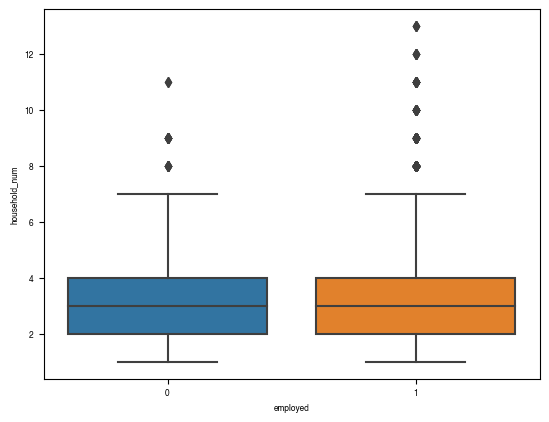

In [ ]:
sns.boxplot(data=train, x='employed', y='household_num')

In [ ]:
train.groupby('employed')['household_num'].mean()

employed
0    3.195039
1    3.019125
Name: household_num, dtype: float64

<AxesSubplot:xlabel='household_num'>

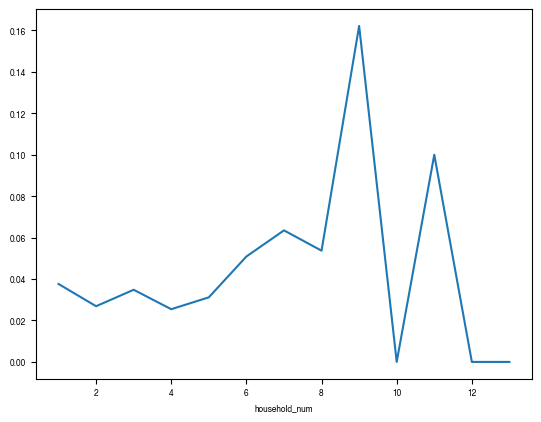

In [ ]:
(1-train.groupby('household_num')['employed'].mean()).plot(kind='line')

In [ ]:
train.household_num.value_counts()

2.0     9002
4.0     5503
3.0     5485
1.0     3588
5.0     2502
6.0     1081
7.0      378
8.0      149
9.0       74
10.0      23
11.0      20
12.0       6
13.0       4
Name: household_num, dtype: int64

### State
* Goal:
    Show Top and Bottom 5 in unemployment rate
* Takeaways
    * Nevada with the highest rate at 5.1%
    * South Dakota with lowest at 1.1%

In [ ]:
1-train.groupby('state')['employed'].mean().sort_values().head()

state
Nevada        0.051075
Kentucky      0.049383
Maine         0.048544
Deleware      0.046429
New Jersey    0.044834
Name: employed, dtype: float64

In [ ]:
1-train.groupby('state')['employed'].mean().sort_values(ascending=False).head()

state
South Dakota    0.011019
Rhode Island    0.012000
North Dakota    0.012315
Minnesota       0.015982
Montana         0.017505
Name: employed, dtype: float64

### Metropolitan and Metro Area Size
* Goal:
    Explore Metro and Metro Area Size 
* Takeaways
    * Not much differenence in either category. Statistical test reject the idea that there is a relationship between unemployement andn different area sizes or rural vs metro. 

chi^2: 0.1847
p: 0.9118
degrees of freedom: 2
Fail to reject null hypothesis
{'metro': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 'non_metro': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274), 'not_identified': (1.0, 0.4980392156862745, 0.054901960784313725)}


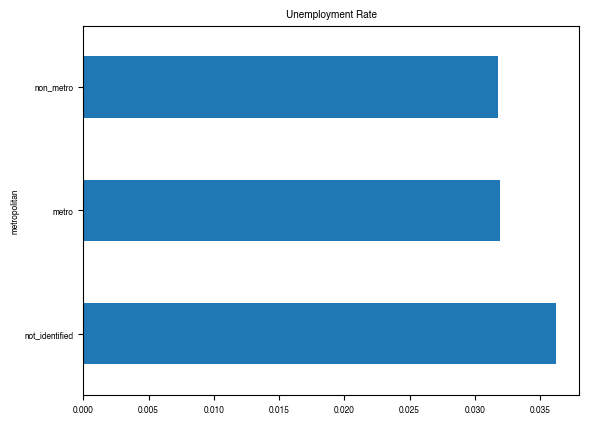

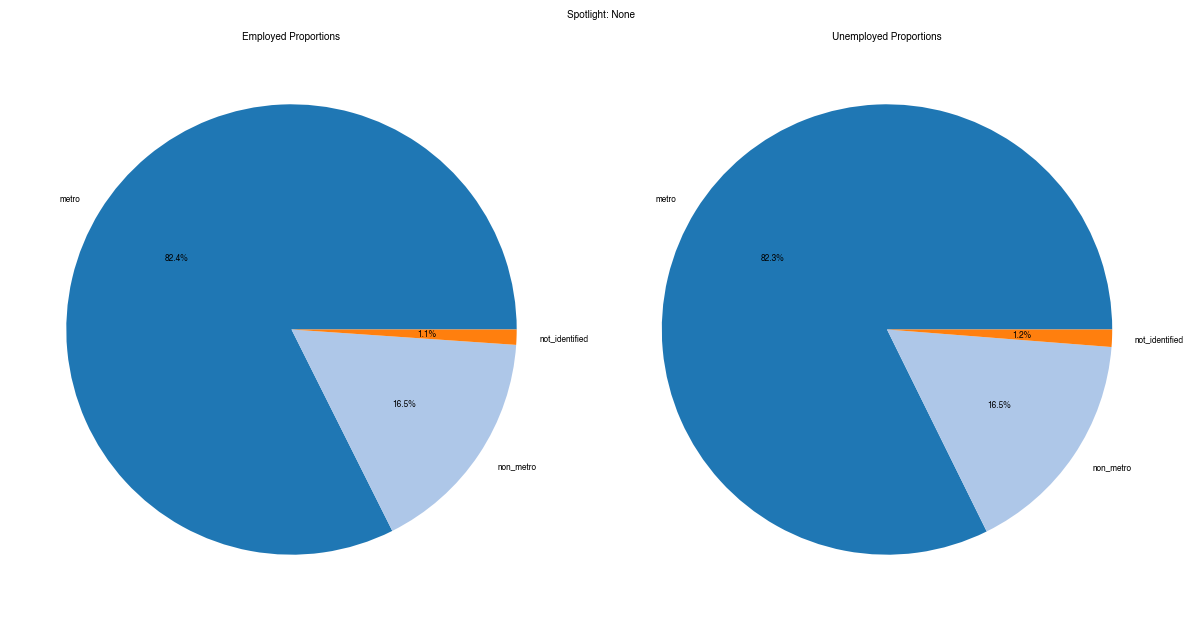

population_proportions                   unemployment_rate
                             employed unemployed change                  
metropolitan                                                             
not_identified                  0.011      0.012  0.002             0.036
metro                           0.824      0.823 -0.001             0.032
non_metro                       0.165      0.165 -0.001             0.032

In [ ]:
spotlight_stats(train, 'metropolitan')

chi^2: 5.5391
p: 0.4767
degrees of freedom: 6
Fail to reject null hypothesis


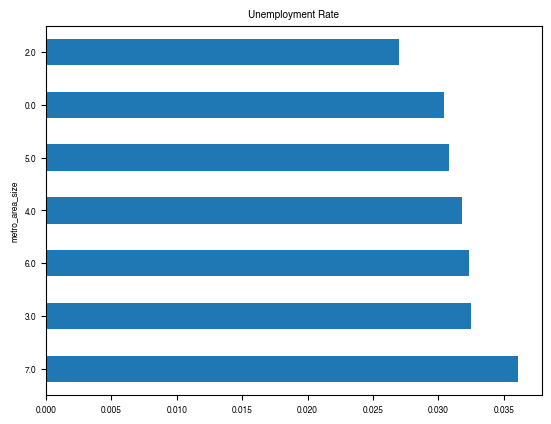

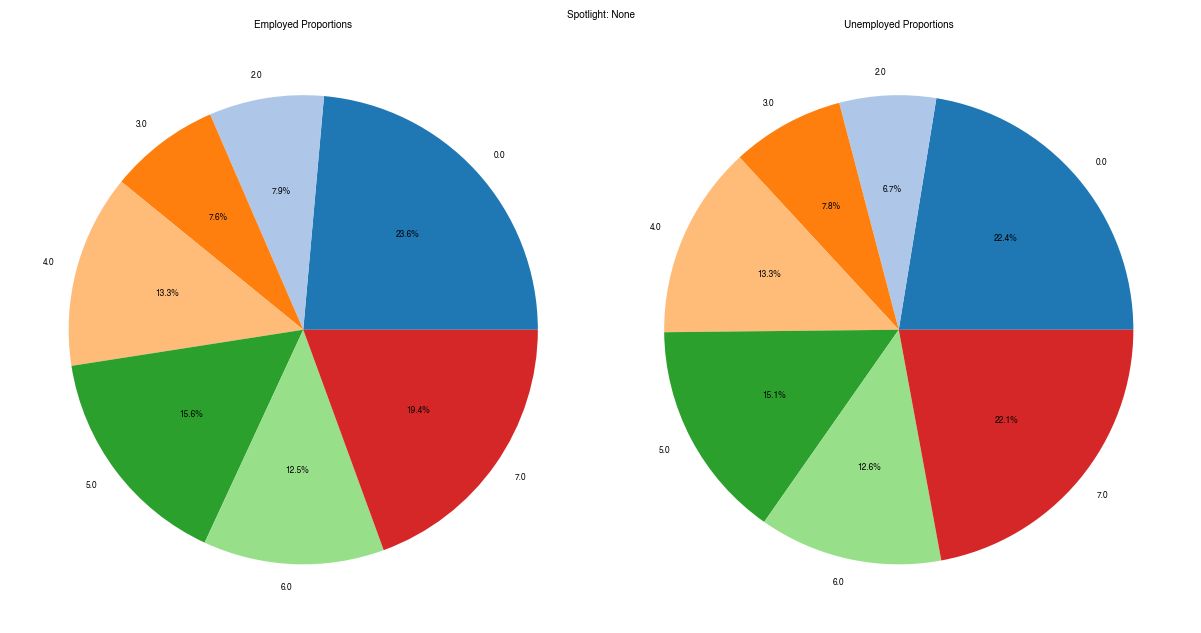

population_proportions                   unemployment_rate
                              employed unemployed change                  
metro_area_size                                                           
7.0                              0.194      0.221  0.027             0.036
3.0                              0.076      0.078  0.002             0.032
6.0                              0.125      0.126  0.002             0.032
4.0                              0.133      0.133 -0.000             0.032
5.0                              0.156      0.151 -0.005             0.031
0.0                              0.236      0.224 -0.012             0.030
2.0                              0.079      0.067 -0.013             0.027

In [ ]:
spotlight_stats(train, 'metro_area_size')

### Age
* Create Box plot that shows mean age
* Use descriptive statistics on unemployed and employed dataframes
* Takeaways 
    * Employed older by 5 years, and a bit more tightly packed.
    * Neither with outliers which can be thought of as accounting for retirement age. 


In [ ]:
train.groupby('employed')['age'].mean()

employed
0    37.865840
1    43.498329
Name: age, dtype: float64

<AxesSubplot:xlabel='employed', ylabel='age'>

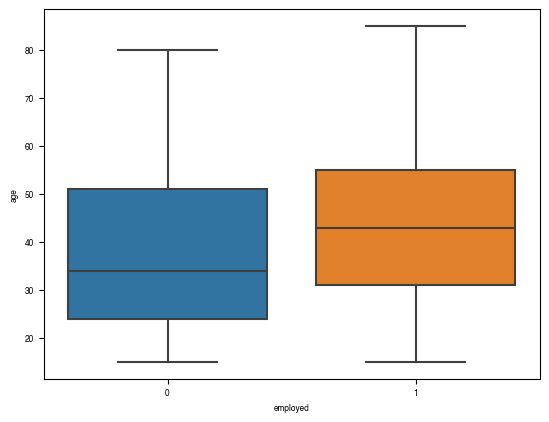

In [ ]:
sns.boxplot(data=train, x='employed', y='age')

### Veteran
* Takeaways
    * Lower unemployement rate for veterans
    * Holds true between service eras. Half a percentage point difference


In [ ]:
1-train.groupby('veteran')['employed'].mean()

veteran
0    0.032506
1    0.020158
Name: employed, dtype: float64

In [ ]:
1-train.groupby(by=['service_era', 'veteran'])['employed'].mean()

service_era  veteran
n/a          0          0.032506
post_gwot    1          0.017058
pre_gwot     1          0.021739
Name: employed, dtype: float64

### Hispanic or non
* Want to find some way to blend this into racial category
* Takeaways
    * Non-Hispanic White have 2.6 unemployement vs 3.5 for Hispanic White (91% of Hispanic)
    * This is the primary driver of their climb in unemployement rate
    * Hispanic Black have 4.4% unemployment, but this is lower than Non-Hispanic Black

In [ ]:
1-train[train.hispanic_or_non ==1].employed.mean()

0.041966148852306984

In [ ]:
train[train.hispanic_or_non ==1].race.value_counts(normalize=True)

white          0.918618
black          0.038952
mixed_white    0.017389
AI/NA          0.012984
asian          0.007883
HI/PI          0.003014
mixed_other    0.001159
Name: race, dtype: float64

In [ ]:
1-train.groupby(['hispanic_or_non', 'race']).employed.mean().unstack()

race,AI/NA,HI/PI,asian,black,mixed_other,mixed_white,white
hispanic_or_non,,,,,,,
0,0.064103,0.046875,0.027105,0.057303,0.08,0.057221,0.025111
1,0.017857,0.000000,0.000000,0.053571,0.20,0.066667,0.041646


---
### Immmigration
* Goals:
    * Explore Immigration features.
    * Create loop for dataframes exploring unemployement rate
* Takeaways:
    * Employement rates stay essentially level
    * Statistical testing suggests that the difference found with parent's birth country may be an anomaly
    * The lack of difference means it is possible to go ahead and remove immigration categories from model in order to reduce noise. Will leave in dframe for future iterations of project that will explore variances in regionality


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27815 entries, 2853 to 29968
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   housing_type                27815 non-null  object  
 1   household_num               27815 non-null  float64 
 2   family_income               27815 non-null  category
 3   household_type              27815 non-null  object  
 4   own_bus_or_farm             27815 non-null  int64   
 5   region                      27815 non-null  object  
 6   state                       27815 non-null  object  
 7   metropolitan                27815 non-null  object  
 8   metro_area_size             27815 non-null  float64 
 9   age                         27815 non-null  float64 
 10  marital_status              27815 non-null  object  
 11  is_male                     27815 non-null  int64   
 12  veteran                     27815 non-null  int64   
 13  education    


---
Mini Spotlight: birth_country propotions
us_50              0.828582
foreign_country    0.166709
us_territories     0.004710
Name: birth_country, dtype: float64
---
chi^2: 6.7814
p: 0.0337
degrees of freedom: 2
Reject null hypothesis
{'foreign_country': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 'us_50': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274), 'us_territories': (1.0, 0.4980392156862745, 0.054901960784313725)}


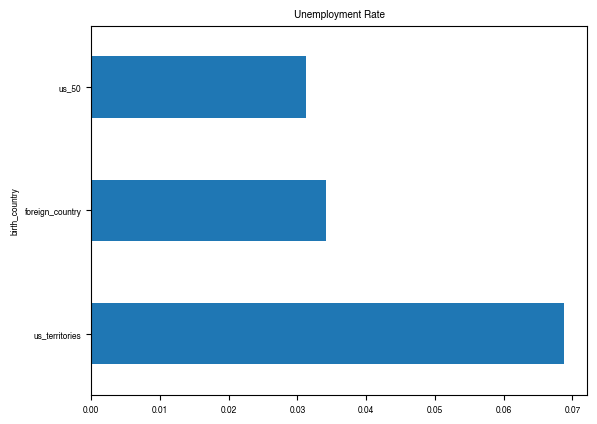

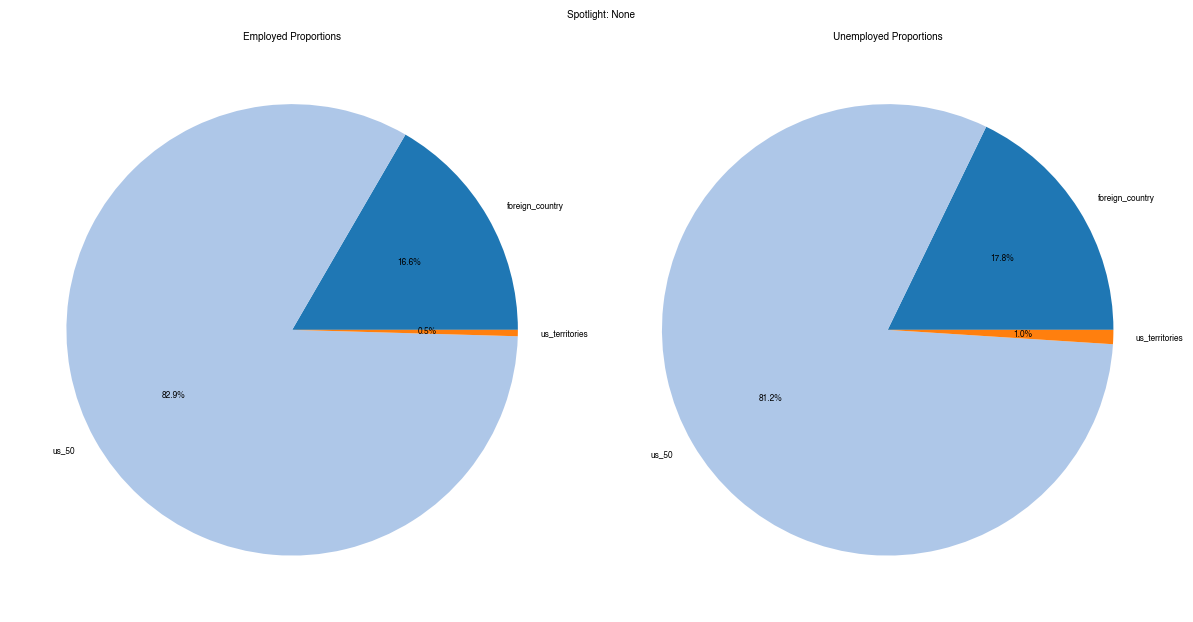

                population_proportions                   unemployment_rate
                              employed unemployed change                  
birth_country                                                             
us_territories                   0.005      0.010  0.006             0.069
foreign_country                  0.166      0.178  0.012             0.034
us_50                            0.829      0.812 -0.017             0.031

---
Mini Spotlight: mother_birth_country propotions
us_50              0.765810
foreign_country    0.227467
us_territories     0.006723
Name: mother_birth_country, dtype: float64
---
chi^2: 7.3862
p: 0.0249
degrees of freedom: 2
Reject null hypothesis
{'foreign_country': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 'us_50': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274), 'us_territories': (1.0, 0.4980392156862745, 0.054901960784313725)}


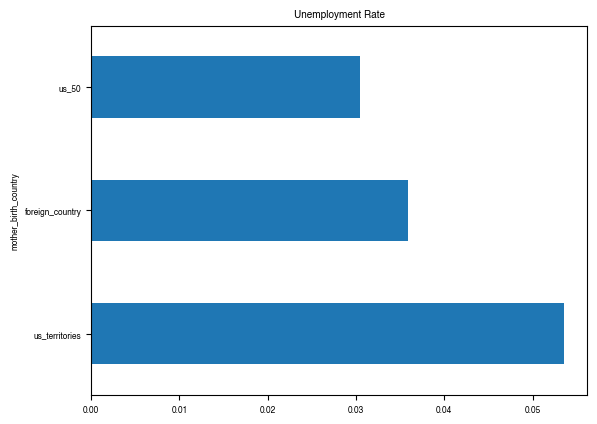

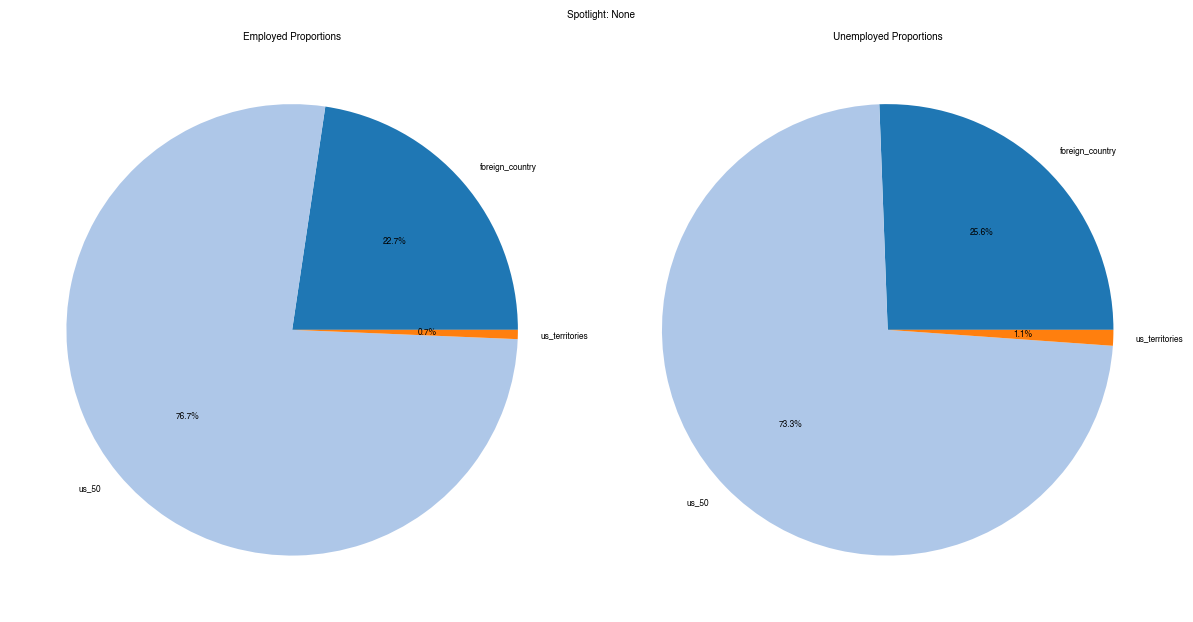

                     population_proportions                    \
                                   employed unemployed change   
mother_birth_country                                            
us_territories                        0.007      0.011  0.005   
foreign_country                       0.227      0.256  0.029   
us_50                                 0.767      0.733 -0.034   

                     unemployment_rate  
                                        
mother_birth_country                    
us_territories                   0.054  
foreign_country                  0.036  
us_50                            0.030  

---
Mini Spotlight: father_birth_country propotions
us_50              0.764695
foreign_country    0.228114
us_territories     0.007190
Name: father_birth_country, dtype: float64
---
chi^2: 3.9436
p: 0.1392
degrees of freedom: 2
Fail to reject null hypothesis
{'foreign_country': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 'us_50': (0.6823529

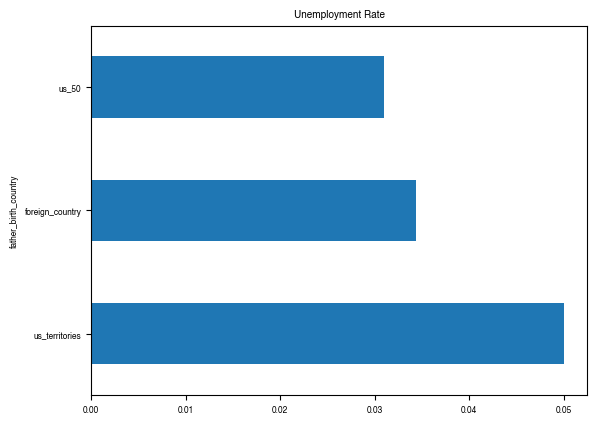

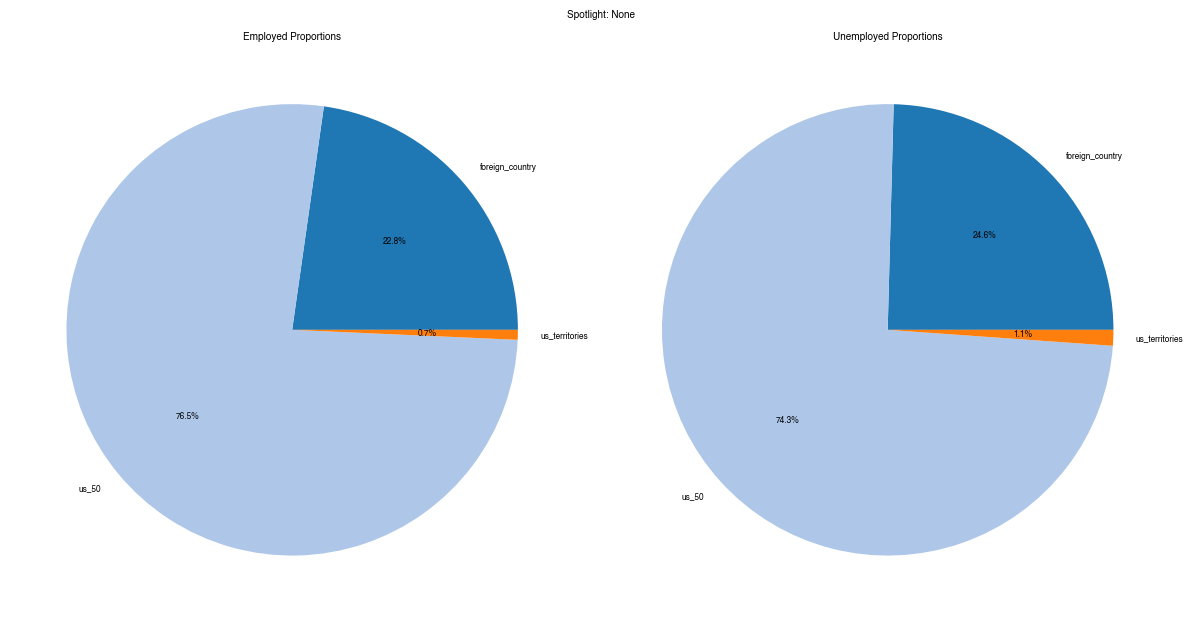

                     population_proportions                    \
                                   employed unemployed change   
father_birth_country                                            
us_territories                        0.007      0.011  0.004   
foreign_country                       0.228      0.246  0.018   
us_50                                 0.765      0.743 -0.022   

                     unemployment_rate  
                                        
father_birth_country                    
us_territories                   0.050  
foreign_country                  0.034  
us_50                            0.031  

---
Mini Spotlight: citizenship propotions
native         0.842783
naturalized    0.078986
foreign        0.078231
Name: citizenship, dtype: float64
---
chi^2: 15.7382
p: 0.0004
degrees of freedom: 2
Reject null hypothesis
{'foreign': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 'native': (0.6823529411764706, 0.7803921568627451, 0.90980392156

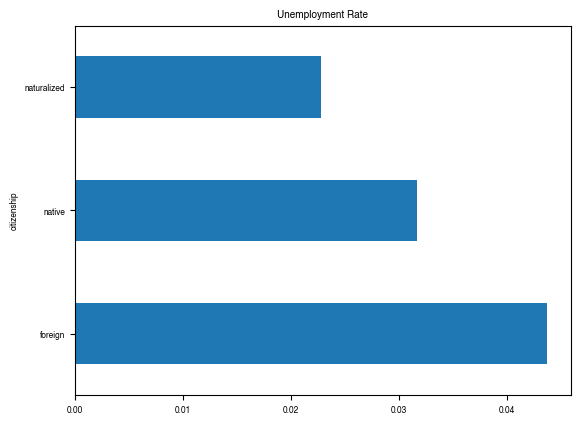

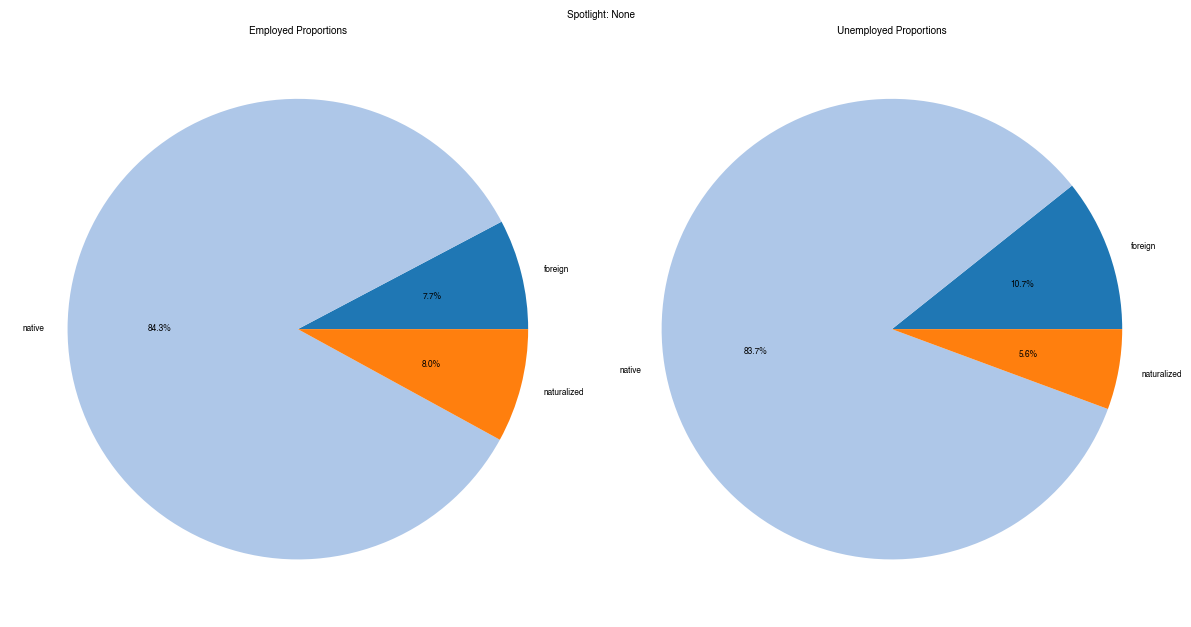

            population_proportions                   unemployment_rate
                          employed unemployed change                  
citizenship                                                           
foreign                      0.077      0.107  0.030             0.044
native                       0.843      0.837 -0.006             0.032
naturalized                  0.080      0.056 -0.023             0.023

---
Mini Spotlight: immigration_era propotions
native       0.828797
post_pwot    0.097393
pre_gwot     0.073809
Name: immigration_era, dtype: float64
---
chi^2: 3.2400
p: 0.1979
degrees of freedom: 2
Fail to reject null hypothesis
{'native': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 'post_pwot': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274), 'pre_gwot': (1.0, 0.4980392156862745, 0.054901960784313725)}


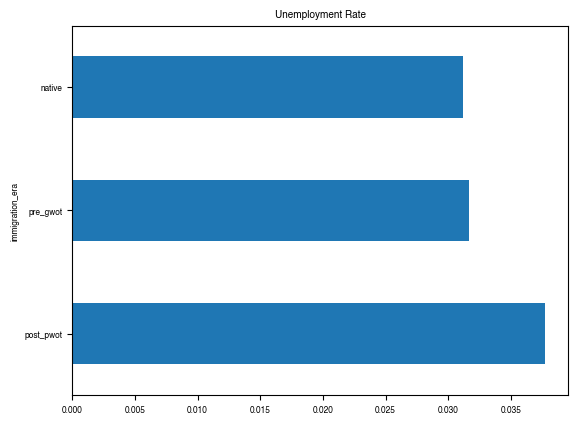

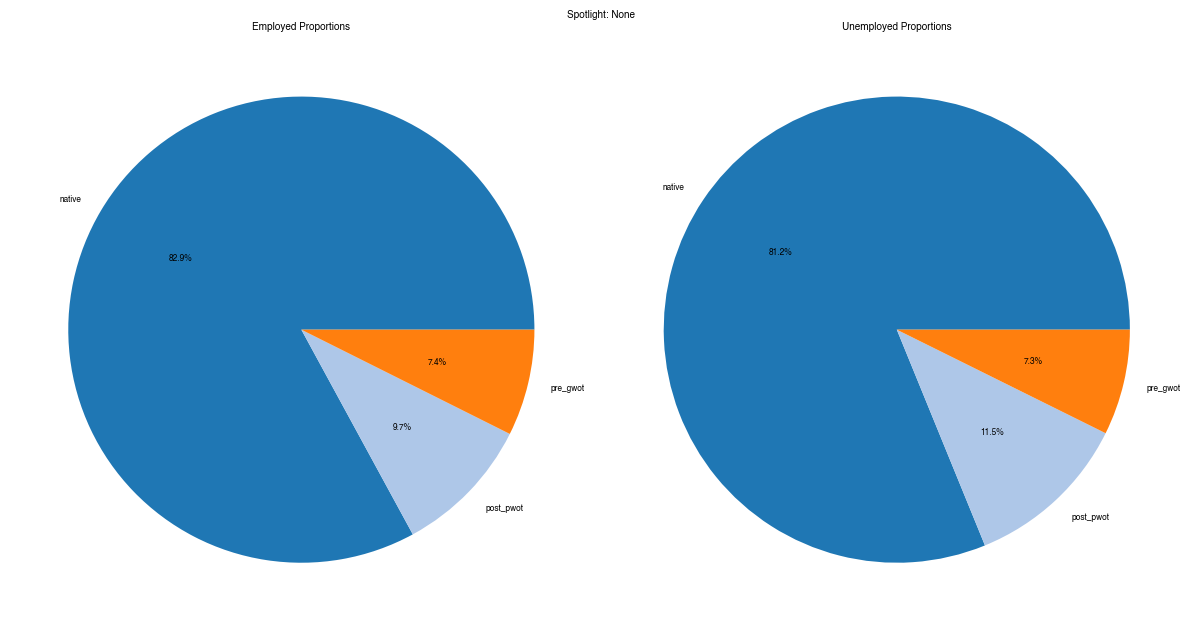

                population_proportions                   unemployment_rate
                              employed unemployed change                  
immigration_era                                                           
post_pwot                        0.097      0.115  0.018             0.038
pre_gwot                         0.074      0.073 -0.001             0.032
native                           0.829      0.812 -0.018             0.031


In [ ]:
#create columns to sort through
immigration_cols = ['birth_country','mother_birth_country','father_birth_country','citizenship', 'immigration_era']
#begin for loop
for col in immigration_cols:
    print('\n---')
    #call spotlight function on each column
    print(f'Mini Spotlight: {col} propotions')
    print(train[col].value_counts(normalize=True))
    print('---')
    print(spotlight_stats(train, col))



---
### Full Time or Part Time

* Goals:
    * exlore regionality, industry, and occupationl differences in part time vs full time work
    * take a look at spotlight stats
* Takeaways:
    * slightly higher unemployement rate, but not dramatically so. 1%. statistically verified
    * East North Central shows 2% gain in unemplouyement rate part time vs full time
    * West North Central showing under 3% employement rate. Will be worth looking at that mixed with industry/occupation
    * Construction, financial activities, information, manufacturing, and public administration show large (2%+)jumps between full time and part time unemployment rates
    * Lesiure and hospitality show a drop, with full time workers in that industry having unemployment of 7.2%


chi^2: 5.2630
p: 0.0218
degrees of freedom: 1
Reject null hypothesis
{'full_time': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 'part_time': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274)}


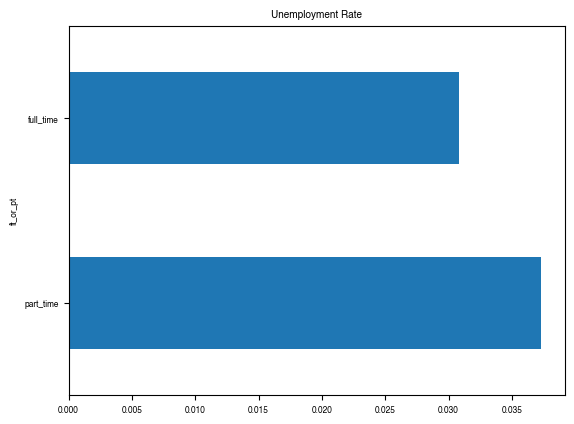

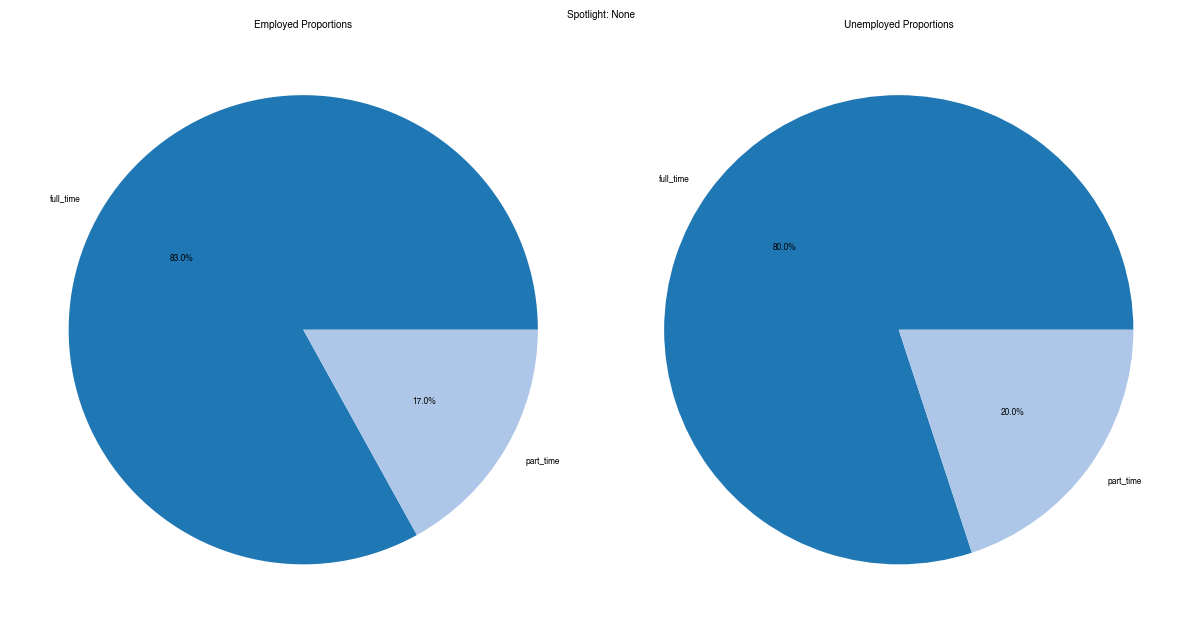

population_proportions                   unemployment_rate
                        employed unemployed change                  
ft_or_pt                                                            
part_time                   0.17        0.2   0.03             0.037
full_time                   0.83        0.8  -0.03             0.031

In [ ]:
spotlight_stats(train, 'ft_or_pt')

In [ ]:
train.groupby(['region','ft_or_pt']).employed.value_counts(normalize=True).unstack()

employed                             0         1
region             ft_or_pt                     
EAST NORTH CENTRAL full_time  0.029711  0.970289
                   part_time  0.042478  0.957522
EAST SOUTH CENTRAL full_time  0.035010  0.964990
                   part_time  0.034615  0.965385
MIDDLE ATLANTIC    full_time  0.036138  0.963862
                   part_time  0.049351  0.950649
MOUNTAIN           full_time  0.031690  0.968310
                   part_time  0.033228  0.966772
NEW ENGLAND        full_time  0.025959  0.974041
                   part_time  0.057737  0.942263
PACIFIC            full_time  0.037383  0.962617
                   part_time  0.031250  0.968750
SOUTH ATLANTIC     full_time  0.029514  0.970486
                   part_time  0.038259  0.961741
WEST NORTH CENTRAL full_time  0.019361  0.980639
                   part_time  0.026585  0.973415
WEST SOUTH CENTRAL full_time  0.030578  0.969422
                   part_time  0.028761  0.971239

In [ ]:
train.groupby(['industry','ft_or_pt']).employed.value_counts(normalize=True).unstack()

employed                                                      0         1
industry                                    ft_or_pt                     
Agriculture, forestry, fishing, and hunting full_time  0.025229  0.974771
                                            part_time  0.008333  0.991667
Construction                                full_time  0.037057  0.962943
                                            part_time  0.064865  0.935135
Educational and health services             full_time  0.020939  0.979061
                                            part_time  0.029576  0.970424
Financial activities                        full_time  0.015844  0.984156
                                            part_time  0.015707  0.984293
Information                                 full_time  0.033040  0.966960
                                            part_time  0.036364  0.963636
Leisure and hospitality                     full_time  0.064363  0.935637
                                            part_time  0.044018  0.955982
Manufacturing                               full_time  0.031288  0.968712
                                            part_time  0.044118  0.955882
Mining                                      full_time  0.023077  0.976923
                                            part_time  0.142857  0.857143
Other services                              full_time  0.023256  0.976744
                                            part_time  0.031073  0.968927
Professional and business services          full_time  0.033277  0.966723
                                            part_time  0.034934  0.965066
Public administration                       full_time  0.009587  0.990413
                                            part_time  0.060976  0.939024
Transportation and utilities                full_time  0.039456  0.960544
                                            part_time  0.045455  0.954545
Wholesale and retail trade                  full_time  0.042322  0.957678
                                            part_time  0.042735  0.957265

---
### num of children
    * Goals:
        * Basic understanding of relationship, and does rate differ with number of children
    * Takeaways
        * May be worth flattening to 4+ children and making categorical
        * seems to be a drop in rate until 3 children, and then it jumps dramatically

In [ ]:
train.num_children.value_counts(normalize=True)

0.0    0.691785
1.0    0.129822
2.0    0.117670
3.0    0.044544
4.0    0.013086
5.0    0.002013
6.0    0.000791
7.0    0.000144
8.0    0.000108
9.0    0.000036
Name: num_children, dtype: float64

<AxesSubplot:xlabel='num_children'>

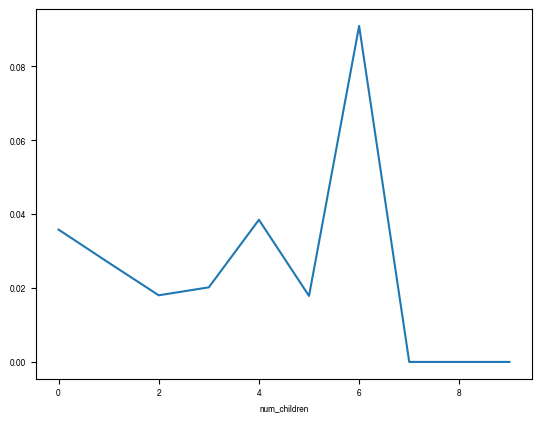

In [ ]:
(1-train.groupby('num_children')['employed'].mean()).plot(kind='line')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27815 entries, 2853 to 29968
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   housing_type                27815 non-null  object  
 1   household_num               27815 non-null  float64 
 2   family_income               27815 non-null  category
 3   household_type              27815 non-null  object  
 4   own_bus_or_farm             27815 non-null  int64   
 5   region                      27815 non-null  object  
 6   state                       27815 non-null  object  
 7   metropolitan                27815 non-null  object  
 8   metro_area_size             27815 non-null  float64 
 9   age                         27815 non-null  float64 
 10  marital_status              27815 non-null  object  
 11  is_male                     27815 non-null  int64   
 12  veteran                     27815 non-null  int64   
 13  education    

# Exploration Summary
## Key Takeways
* Industry
    * `Leisure and hospitality` with highest industry unemployment rate, highest jump in proportionality
    * Regionality played large factor in unemployment rate variance within various industries
    * information with highest unemployement rate (5.7%) in Pacific where it makes up highest percetange of workforce nationwide (2.5%). `blacks` with triple unemployment rate in professional and business services
* Occupation
   * `service` occupations highest change in proportionality
   * ONLY management, and profession occupations have less that 49% with only high school /ged level education. the same with more 10% post_grad
    * construction, farming, service occupations all have greter than 15% with no high school
* Marital Status
    * `single` individuals with highest unemployment rate, 5% vs 2%, highest jump in proportionality
    * proportinality difference is more than a simple doubling of income.
    * 34% of single make less than 50k but over 50% of married have household income more than 100k
    * 28% of married have professional certification, 19% of single individuals. Can possibly be explained by average single person being 8 years younger than the average age of those with professional certifications
    * professional occupations show much greater proportionality. 44% of those employed with professional certification work in those occupations. 2nd highest is management, business, and financial occupations
* Race
    * `mixed_raced_other` top of unemployed
    * `indeginous`, `black`, and `hi/pi` among tops in unemployment rate
* Professional Certification and Education
    * 4x the unemployment rate for those without a professional_certification vs those with
    * those with professsional certification more likely to have completed bachelor's and above. largest gains in post_grad area. 19% greater proportionality. Much less likely to have no high school diploma/ged 
* General
    * Climbs in unemployement rate as families grow larger
    * Employed older by 5 years, and a bit more tightly packed.
    * Non-Hispanic White have 2.6 unemployement vs 3.5 for Hispanic White (91% of Hispanic)
    * Hispanic Black have 4.4% unemployment, but this is lower than Non-Hispanic Black

------------
## Overall Summary
* Overall the conventional wisdom surrounding job prospects held true. 
* It benefits an indvidual to acquire advanced dregrees and certifications
* Having a job or career in an industry that leans more towards being a profession helps
* No major differences in takeaways from October data, but did make additional discoveries

------------


In [ ]:
train.to_csv('oct2022.csv')